# Weather Analysis for Hurricane Prediction
In this project, I'm looking to find within generic weather data indication about an upcoming hurricane.

This is very far from state of the art weather prediction but I find it incredible how far in the analysis you can get with no prior knowledge, just enough data and simple Data Science tools.

In this project, I'm using google bigquerry to analyse google public databases. In particular, I'm exploring the land weather stations database, the sea weather stations (boats mainly) database and the hurricanes database.

First load the libraries you will need...

In [1]:
import sys,os
import pandas as pd
from google.cloud import bigquery
import pickle
import matplotlib.pyplot as plt
# import plotly.plotly as py
# py.init_notebook_mode(connected=True)
from mpl_toolkits.basemap import Basemap
from bq_helper import BigQueryHelper
from geopy.distance import great_circle
import numpy as np
from math import cos, sin, asin, sqrt, pi

PATH_DATA = 'E:\\DataScience\\Data\\WeatherProject\\'

In [124]:
from sklearn.neighbors import BallTree
import itertools
from sklearn.preprocessing import StandardScaler


Here I'm defining some helper functions that will help me visualize the results along the way.

In [3]:
def plot_data(list_lon, list_lat, center_lon, center_lat, title_val,marker_size=1, **keyword_parameters):
    m = Basemap(projection='ortho',lon_0=center_lon,lat_0=center_lat,resolution='l')
    m.drawcoastlines()
    m.drawparallels(np.arange(-90.,120.,30.))
    m.drawmeridians(np.arange(0.,420.,60.))
    plt.title(title_val)
    x,y = m(list_lon, list_lat)
    if ('list_val' in keyword_parameters):
        m.fillcontinents(color='coral',lake_color='aqua',alpha=0.1)
        m.scatter(x, y, c=keyword_parameters['list_val'], cmap='seismic',s=marker_size)
    else:
        m.fillcontinents(color='coral',lake_color='aqua',alpha=1)
        m.plot(x, y, 'bo', markersize=marker_size)
        m.drawmapboundary(fill_color='aqua')

In [4]:
def great_circle_kmeter(p1, p2):
    return great_circle(p2, p1).kilometers

## Define a network of points to average the measures on
My first working hypothesis is to aggregate the measures on a mesh of points around the globe. There is too much data to use it raw. I'm just looking for a rough precision (about 80km radius).

In [5]:
earth_radius = 12742/2
earth_perimeter = 12742 * pi

lat_g = np.array(range(-180,182,3))/2.
dist_layers = earth_perimeter/(len(lat_g)-1)

map_lon, map_lat = [], []
prev_mid = 0
for lat_i in lat_g:
    r = cos(lat_i*pi/180)*earth_radius
    num_points = int(2*pi*r/dist_layers)+1
    for i in range(num_points):
        map_lon.append((prev_mid + i*360/num_points)%360)
        map_lat.append(lat_i)
    prev_mid = (prev_mid + 180/num_points)%360

    
print('Number of location selected: ' + str(len(map_lat)))
print('Distance between 2 locations (km): '+str(great_circle([map_lat[2],map_lon[2]],[map_lat[1],map_lon[1]]).kilometers))

Number of location selected: 9231
Distance between 2 locations (km): 166.792625586


In [6]:
point_lat = np.array(map_lat)
point_lon = np.array(map_lon)


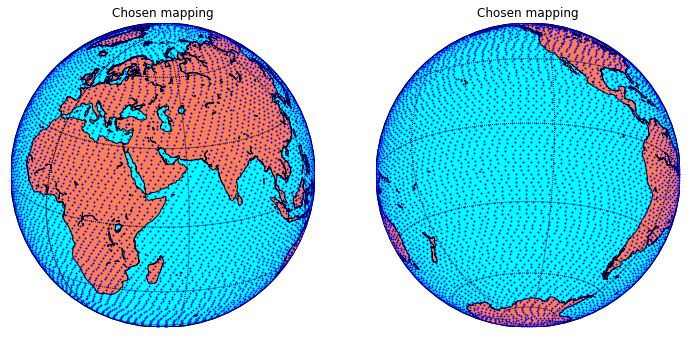

In [17]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plot_data(map_lon, map_lat, 50, 20, 'Chosen mapping')
plt.subplot(1,2,2)
plot_data(map_lon, map_lat, 230, -20, 'Chosen mapping')
plt.show()

In [25]:
grid = np.array([map_lat,map_lon]).T

## Set Up Credentials for big_querry and tables exploration
Now let get some data. Thanks to the National Oceanic and Atmospheric Administration for collecting it. Thanks to Google for making it easily available. We are going to use Google's big querry to build our databases.



In [79]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = r"C:\Users\Julie\Documents\Jeremie\ITC\PersonalProject\Sand Box-1119fd811a45.json"

In [81]:
# First creat BigQueryHelper objects
bq_assistant = BigQueryHelper("bigquery-public-data", "noaa_gsod")
bq_boat_asstnt = BigQueryHelper("bigquery-public-data", "noaa_icoads")
bq_hurricanes_asstnt = BigQueryHelper("bigquery-public-data", "noaa_hurricanes")

In [83]:
# General Exploration
%time
land_tables = bq_assistant.list_tables()
boat_tables = bq_boat_asstnt.list_tables()
hurricanes_tables = bq_hurricanes_asstnt.list_tables()

Wall time: 0 ns


This is some General Exploration of the data we have loaded.

In [86]:
%time
land_head = bq_assistant.head("gsod2017", num_rows=2)
station_head = bq_assistant.head("stations", num_rows=2)
boats_head = bq_boat_asstnt.head("icoads_core_2017", num_rows=2)
hurricanes_head = bq_hurricanes_asstnt.head("hurricanes", num_rows=2)

Wall time: 0 ns


In [90]:
%time
land_schema = bq_assistant.table_schema("gsod2017")
station_schema = bq_assistant.table_schema("stations")
boat_schema = bq_boat_asstnt.table_schema("icoads_core_2017")
hurricanes_schema = bq_hurricanes_asstnt.table_schema("hurricanes")

Wall time: 0 ns


In [92]:
hurricanes_head

,usa_r34_nw,reunion_r64_ne,newdelhi_poci,nadi_pressure,usa_r34_ne,bom_roci,usa_record,nadi_longitude,subbasin,neumann_pressure,...,bom_tnum,nadi_cat,usa_r34_sw,tokyo_r50_dir,wellington_pressure,hko_latitude,td9635_wind,usa_r34_se,mlc_longitude,tokyo_longitude
0,1971275N10176,1971,131,WP,MM,FAYE(GLORIA):GLORIA,1971-10-08 18:00:00+00:00,TS,14.1889,130.356,...,None,,None,None,None,None,,None,None,WP311971
1,1971275N10176,1971,131,WP,MM,FAYE(GLORIA):GLORIA,1971-10-08 12:00:00+00:00,TS,14.3273,131.136,...,None,,None,None,None,None,,None,None,WP311971


In [12]:
# boats_head.columns

The full description of each feature is available on the schemas we extracted. We'll use the most logical ones to start our exploration.

In [69]:
# initial features selection
# These are day averages
land_features = ['stn', 'wban', 'year', 'mo', 'da', 'temp', 'dewp',
       'slp', 'stp', 'wdsp', 'max', 'min', 'prcp', 'sndp', 'fog', 'rain_drizzle',
       'snow_ice_pellets', 'hail', 'thunder', 'tornado_funnel_cloud']

## Load weather stations data
Now we are looking at the weather stations themselves not their measures.

In [14]:
# First query
query ='''SELECT usaf, wban, country, lat, lon FROM `bigquery-public-data.noaa_gsod.stations`'''

In [14]:
%%time
bq_assistant.estimate_query_size(query)

Wall time: 461 ms


0

Loading the data take a while and takes a lot of memory. We'll be saving it with pickle in order to have the data easily available on demand without clogging the notebook memory. We'll be using the same trick a few time along this notebook. 

In [15]:
# stations = bq_assistant.query_to_pandas_safe(query)

In [16]:
# with open(PATH_DATA + 'stations.p','wb') as my_file:
#     pickle.dump(stations, my_file)

In [3]:
with open(PATH_DATA + 'stations.p','rb') as my_file:
    stations = pickle.load(my_file)

Let's check the number of stations.

In [4]:
stations.shape

(29628, 5)

What about their distribution on the globe?

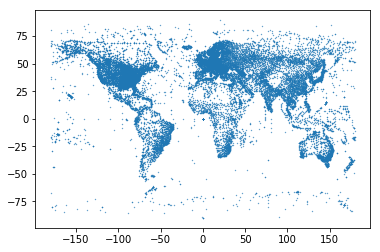

179.75
29628


In [5]:
plt.scatter(stations.lon,stations.lat,s=.1)
plt.show()
print(max(stations.lon.values))
print(len(stations.lon.values))

## Plot all stations on globe
Here we are going to get rid of duplicates and group stations according to our previous mesh.

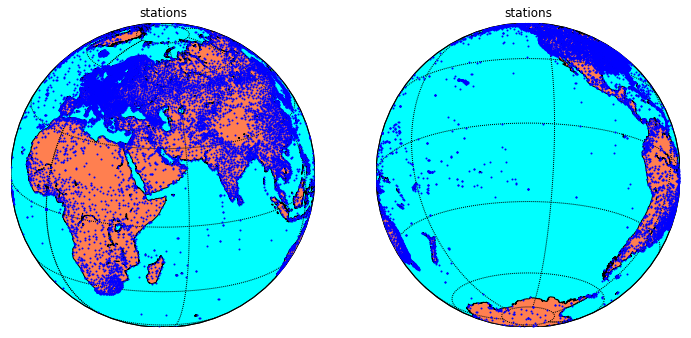

In [16]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plot_data(stations.lon.values, stations.lat.values, 50, 20, 'stations')
plt.subplot(1,2,2)
plot_data(stations.lon.values, stations.lat.values, 230, -20, 'stations')
plt.show()

In [28]:
# Getting rid of duplicates stations or station with missing coordinates
stations_light = stations.loc[stations[['lat','lon']].notnull().all(1),:].drop_duplicates(subset=['usaf'], keep = 'first')

In [30]:
my_tree = BallTree(stations_light[['lat','lon']].values, metric = great_circle_kmeter, leaf_size=2)

In [32]:
## Getting stations within 1.25 radius from center (create overlap to cover all globe)
list_neighbors = my_tree.query_radius(zip(map_lat,map_lon),dist_layers/2*1.25)

In [35]:
stations_per_point = [list(stations_light.iloc[neigh].usaf) for neigh in list_neighbors]

In [240]:
# with open(PATH_DATA + 'stations_per_point.p','wb') as my_file:
#     pickle.dump(stations_per_point, my_file)

In [84]:
with open(PATH_DATA + 'stations_per_point.p','rb') as my_file:
    stations_per_point = pickle.load(my_file)

## get actual measurements - save and load via hdf
Given the size of the database, we are limiting our analysis to 2016 and 2017.

In [195]:
query2 ='SELECT ' + ', '.join(land_features) + ' FROM `bigquery-public-data.noaa_gsod.gsod2017`'
print(query2)

SELECT stn, wban, year, mo, da, temp, dewp, slp, stp, wdsp, max, min, prcp, sndp, fog, rain_drizzle, snow_ice_pellets, hail, thunder, tornado_funnel_cloud FROM `bigquery-public-data.noaa_gsod.gsod2017`


In [70]:
query2 ='SELECT ' + ', '.join(land_features) + ' FROM `bigquery-public-data.noaa_gsod.gsod2016`'
print(query2)

SELECT stn, wban, year, mo, da, temp, dewp, slp, stp, wdsp, max, min, prcp, sndp, fog, rain_drizzle, snow_ice_pellets, hail, thunder, tornado_funnel_cloud FROM `bigquery-public-data.noaa_gsod.gsod2016`


In [71]:
%%time
bq_assistant.estimate_query_size(query2)

Wall time: 1.22 s


0

In [200]:
# land2017 = bq_assistant.query_to_pandas_safe(query2)
# land2017.to_hdf(PATH_DATA + 'test.h5',key='land2017',mode='w')

In [81]:
# land2016 = bq_assistant.query_to_pandas_safe(query2)


In [73]:
land2016.to_hdf(PATH_DATA + 'land2016.h5',key='land2016',mode='w')
land2016.shape

C:\Users\Julie\Anaconda3\envs\project3.6\lib\site-packages\pandas\io\pytables.py:279: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->unicode,key->axis0] [items->None]

  f(store)
C:\Users\Julie\Anaconda3\envs\project3.6\lib\site-packages\pandas\io\pytables.py:279: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->unicode,key->block0_items] [items->None]

  f(store)
C:\Users\Julie\Anaconda3\envs\project3.6\lib\site-packages\pandas\core\generic.py:1996: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->unicode,key->block1_values] [items->[u'stn', u'wban', u'year', u'mo', u'da', u'wdsp', u'fog', u'rain_drizzle', u'snow_ice_pellets', u'hail', u'thunder', u'tornado_funnel_cloud']]

  return pytables.to_hdf(path_or_buf, 

(4292866, 20)

In [6]:
land2016 = pd.read_hdf(PATH_DATA + 'land2016.h5')
land2017 = pd.read_hdf(PATH_DATA + 'test.h5')

 SchemaField(u'temp', u'FLOAT', u'NULLABLE', u'Mean temperature for the day in degrees Fahrenheit to tenths. Missing = 9999.9', ()),
 SchemaField(u'dewp', u'FLOAT', u'NULLABLE', u'Mean dew point for the day in degreesm Fahrenheit to tenths.  Missing = 9999.9', ()),
 SchemaField(u'slp', u'FLOAT', u'NULLABLE', u'Mean sea level pressure for the day in millibars to tenths. Missing = 9999.9', ()),
 SchemaField(u'stp', u'FLOAT', u'NULLABLE', u'Mean station pressure for the day in millibars to tenths. Missing = 9999.9', ()),
 SchemaField(u'visib', u'FLOAT', u'NULLABLE', u'Mean visibility for the day in miles to tenths.  Missing = 999.9', ()),
 SchemaField(u'wdsp', u'STRING', u'NULLABLE', u'Mean wind speed for the day in knots to tenths. Missing = 999.9', ()),
 SchemaField(u'mxpsd', u'STRING', u'NULLABLE', u'Maximum sustained wind speed reported for the day in knots to tenths. Missing = 999.9', ()),
 SchemaField(u'gust', u'FLOAT', u'NULLABLE', u'Maximum wind gust reported for the day in knots to tenths. Missing = 999.9', ()),
 SchemaField(u'max', u'FLOAT', u'NULLABLE', u'Maximum temperature reported during the day in Fahrenheit to tenths--time of max temp report varies by country and region, so this will sometimes not be the max for the calendar day. Missing = 9999.9', ()),
 SchemaField(u'min', u'FLOAT', u'NULLABLE', u'Minimum temperature reported during the day in Fahrenheit to tenths--time of min temp report varies by country and region, so this will sometimes not be the min for the calendar day. Missing = 9999.9', ()),
 SchemaField(u'prcp', u'FLOAT', u'NULLABLE', u"Total precipitation (rain and/or melted snow) reported during the day in inches and hundredths; will usually not end with the midnight observation--i.e., may include latter part of previous day.  .00 indicates no measurable precipitation (includes a trace). Missing = 99.99 Note: Many stations do not report '0' on days with no precipitation--therefore, '99.99' will often appear on these days. Also, for example, a station may only report a 6-hour amount for the period during which rain fell. See Flag field for source of data", ()),
 SchemaField(u'sndp', u'FLOAT', u'NULLABLE', u"Snow depth in inches to tenths--last report for the day if reported more thanonce. Missing = 999.9 Note: Most stations do not report '0' ondays with no snow on the ground--therefore, '999.9' will often appear on these days", ()),

Another helper function to clean up our data.

In [7]:
def apply_nan(df):
    df.temp[df.temp==9999.9] = np.nan
    df.dewp[df.dewp==9999.9] = np.nan
    df.slp[df.slp==9999.9] = np.nan
    df.stp[df.stp==9999.9] = np.nan
    df.wdsp[df.wdsp==999.9] = np.nan
    df['max'][df['max']==9999.9] = np.nan
    df['min'][df['min']==9999.9] = np.nan
    df.prcp[df.prcp==99.99] = np.nan
    df.sndp[df.sndp==999.9] = np.nan
    return df

In [8]:
land2017 = apply_nan(land2017)

C:\Users\Julie\Anaconda3\envs\project3.6\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Julie\Anaconda3\envs\project3.6\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\Julie\Anaconda3\envs\project3.6\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Julie\Anaconda3\envs\project

In [9]:
land2016 = apply_nan(land2016)

C:\Users\Julie\Anaconda3\envs\project3.6\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Julie\Anaconda3\envs\project3.6\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\Julie\Anaconda3\envs\project3.6\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Julie\Anaconda3\envs\project

### Averaging data per point of my network

This function is used for aggregation of the data per point in the mesh per day.

For most data a simple average is the best. For the boolean data, we'd rather aggregate with max.

In [ ]:
def point_data(df):
    agg_dic = {col:'mean' for col in df.columns}
    temp = ['fog','rain_drizzle','snow_ice_pellets','hail','thunder','tornado_funnel_cloud']
    for t in temp:
        agg_dic[t] = 'max'
    temp = ['stn','wban','year','mo','da']
    for t in temp:
        del agg_dic[t]

    newDF = pd.DataFrame()
    for i, point in enumerate(stations_per_point):
        if i%10 == 0:
            print(i)
        temp = df[df.stn.isin(list(point))].iloc[:,2:].astype(float).groupby(['year', 'mo', 'da']).agg(agg_dic)
        temp['point'] = i
        newDF = newDF.append(temp)
        
    return newDF

In [ ]:
dataLand2017 = point_data(land2017)

In [ ]:
dataLand2016 = point_data(land2016)

In [246]:
# dataLand2017.to_hdf(PATH_DATA + 'dataLand.h5',key='dataLand2017',mode='w')

C:\Users\Julie\Anaconda3\envs\project3.6\lib\site-packages\pandas\io\pytables.py:279: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->axis0] [items->None]

  f(store)
C:\Users\Julie\Anaconda3\envs\project3.6\lib\site-packages\pandas\io\pytables.py:279: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->unicode,key->block0_items] [items->None]

  f(store)


In [88]:
# dataLand2016.to_hdf(PATH_DATA + 'dataLand16.h5',key='dataLand2016',mode='w')

C:\Users\Julie\Anaconda3\envs\project3.6\lib\site-packages\pandas\io\pytables.py:279: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->axis0] [items->None]

  f(store)


In [8]:
dataLand2016 = pd.read_hdf(PATH_DATA + 'dataLand16.h5')

In [9]:
dataLand2017 = pd.read_hdf(PATH_DATA + 'dataLand.h5')

In [10]:
dataLand2017.sortlevel(inplace=True)

C:\Users\Julie\Anaconda3\envs\project3.6\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  if __name__ == '__main__':


In [11]:
dataLand2016.sortlevel(inplace=True)

C:\Users\Julie\Anaconda3\envs\project3.6\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  if __name__ == '__main__':


In [12]:
# dataLand2017.loc[2017,1,:7]

Now we can visualize the data. For instance, we could look at the temperature on earth January 2nd 2017.

C:\Users\Julie\Anaconda3\envs\project3.6\lib\site-packages\mpl_toolkits\basemap\__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


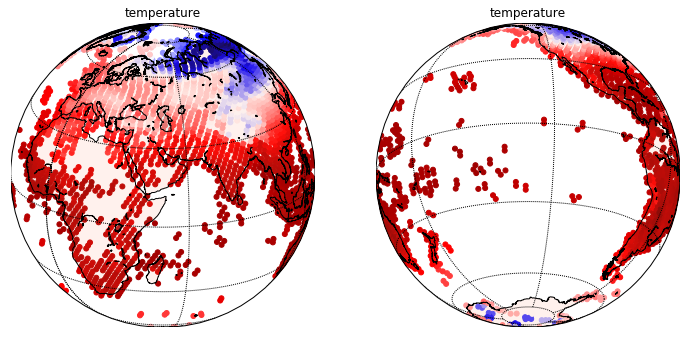

In [13]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plot_data(point_lon[dataLand2017.loc[(2017,1,2)].point.values], point_lat[dataLand2017.loc[(2017,1,2)].point.values],\
          50, 20, 'temperature', 25, list_val= dataLand2017.loc[(2017,1,2)].temp.values)
plt.subplot(1,2,2)
plot_data(point_lon[dataLand2017.loc[(2017,1,2)].point.values], point_lat[dataLand2017.loc[(2017,1,2)].point.values],\
          230, -20, 'temperature', 25, list_val=dataLand2017.loc[(2017,1,2)].temp.values)
plt.show()

### Let's now clean the data

In [90]:
print(dataLand2016.shape)
# dataLand2017.loc[2017,1,1].shape

i=0
for element in itertools.product(*dataLand2016.index.levels):
    
    try:
        print(dataLand2016.loc[element].shape)
        i+=1
    except:
        pass
print(str(i) + ' days with data')

(1245712, 16)
(3375, 16)
(3353, 16)
(3351, 16)
(3377, 16)
(3397, 16)
(3402, 16)
(3412, 16)
(3380, 16)
(3361, 16)
(3357, 16)
(3402, 16)
(3409, 16)
(3407, 16)
(3399, 16)
(3417, 16)
(3399, 16)
(3391, 16)
(3393, 16)
(3406, 16)
(3404, 16)
(3422, 16)
(3406, 16)
(3366, 16)
(3362, 16)
(3404, 16)
(3405, 16)
(3407, 16)
(3384, 16)
(3387, 16)
(3381, 16)
(3396, 16)
(3386, 16)
(3397, 16)
(3379, 16)
(3404, 16)
(3404, 16)
(3373, 16)
(3356, 16)
(3370, 16)
(3421, 16)
(3422, 16)
(3402, 16)
(3390, 16)
(3370, 16)
(3400, 16)
(3371, 16)
(3416, 16)
(3403, 16)
(3370, 16)
(3417, 16)
(3401, 16)
(3377, 16)
(3387, 16)
(3398, 16)
(3414, 16)
(3420, 16)
(3400, 16)
(3371, 16)
(3374, 16)
(3405, 16)
(3429, 16)
(3405, 16)
(3393, 16)
(3377, 16)
(3389, 16)
(3375, 16)
(3406, 16)
(3399, 16)
(3416, 16)
(3427, 16)
(3432, 16)
(3377, 16)
(3360, 16)
(3394, 16)
(3429, 16)
(3419, 16)
(3404, 16)
(3387, 16)
(3372, 16)
(3382, 16)
(3404, 16)
(3404, 16)
(3313, 16)
(3399, 16)
(3404, 16)
(3389, 16)
(3382, 16)
(3384, 16)
(3389, 16)
(3428, 

#### checking for %age of NAN and dealing with it

In [91]:
for col in dataLand2016.columns:
    print(col+':'+str(sum(dataLand2016[col].isnull())*1.0/len(dataLand2016[col].isnull())))

wdsp:0.0
snow_ice_pellets:0.0
temp:0.0
min:0.000334748320639
max:0.000217546270727
sndp:0.860351349269
slp:0.123936351259
hail:0.0
dewp:0.0410801212479
fog:0.0
stp:0.176663626906
rain_drizzle:0.0
thunder:0.0
prcp:0.0173916603517
tornado_funnel_cloud:0.0
point:0.0


In [14]:
def complete_nan(df):
    df.loc[df['min'].isnull(),'min'] = df.loc[df['min'].isnull(),'temp']
    df.loc[df['max'].isnull(),'max'] = df.loc[df['max'].isnull(),'temp']
    df['prcp'] = df['prcp'].fillna(0)
    df['sndp'] = df['sndp'].fillna(0)
    df['dewp'] = df['dewp'].fillna(df['dewp'].mean())
    return df

In [15]:
dataLand2016 = complete_nan(dataLand2016)

In [16]:
dataLand2017 = complete_nan(dataLand2017)

In [17]:
for col in dataLand2016.columns:
    print(col+':'+str(sum(dataLand2016[col].isnull())*1.0/len(dataLand2016[col].isnull())))

wdsp:0.0
snow_ice_pellets:0.0
temp:0.0
min:0.0
max:0.0
sndp:0.0
slp:0.123936351259
hail:0.0
dewp:0.0
fog:0.0
stp:0.176663626906
rain_drizzle:0.0
thunder:0.0
prcp:0.0
tornado_funnel_cloud:0.0
point:0.0


In [96]:
k=0
l=0
for i, j in dataLand2016[['slp','stp','point']].groupby('point'):
    if j['slp'].isnull().all():
        l+=1
    k+=1
l*1.0/k

0.10285244103126714

Too much pressure data is missing. I won't be able to use it for the analysis so let's drop it from our database.

In [18]:
prepLand2017 = dataLand2017.drop(['slp','stp'],axis=1)

In [19]:
prepLand2016 = dataLand2016.drop(['slp','stp'],axis=1)

In [101]:
# prepLand2016.to_hdf(PATH_DATA + 'prepLand16.h5',key='prepLand2016',mode='w')

In [25]:
# prepLand2017.to_hdf(PATH_DATA + 'prepLand.h5',key='prepLand2017',mode='w')

C:\Users\Julie\Anaconda3\envs\project3.6\lib\site-packages\pandas\io\pytables.py:279: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->axis0] [items->None]

  f(store)
C:\Users\Julie\Anaconda3\envs\project3.6\lib\site-packages\pandas\io\pytables.py:279: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->unicode,key->block0_items] [items->None]

  f(store)


In [6]:
prepLand2017 = pd.read_hdf(PATH_DATA + 'prepLand.h5')

In [6]:
prepLand2016 = pd.read_hdf(PATH_DATA + 'prepLand16.h5')

In [20]:
prepLand = prepLand2016.append(prepLand2017)

Let's look at the first enrty:

In [8]:
prepLand[prepLand.point==0].head()

wdsp  snow_ice_pellets  temp   min   max  sndp  hail  \
year   mo  da                                                          
2016.0 1.0 1.0   7.6               1.0 -19.7 -22.0 -17.7   0.0   0.0   
           2.0  13.3               1.0 -16.6 -22.2 -14.8   0.0   0.0   
           3.0   8.7               1.0 -11.5 -17.3  -9.4   0.0   0.0   
           4.0  10.2               0.0 -17.3 -18.4  -7.1   0.0   0.0   
           5.0  12.0               0.0 -18.0 -18.6 -16.6   0.0   0.0   

                     dewp  fog  rain_drizzle  thunder  prcp  \
year   mo  da                                                 
2016.0 1.0 1.0  46.686282  0.0           0.0      0.0   0.0   
           2.0  46.686282  0.0           0.0      0.0   0.0   
           3.0  46.686282  0.0           0.0      0.0   0.0   
           4.0  46.686282  0.0           0.0      0.0   0.0   
           5.0  46.686282  0.0           0.0      0.0   0.0   

                tornado_funnel_cloud  point  
year   mo  da                                
2016.0 1.0 1.0                   0.0      0  
           2.0                   0.0      0  
           3.0                   0.0      0  
           4.0                   0.0      0  
           5.0                   0.0      0

In [9]:
for p_point in prepLand.point.unique():
    prepLand.loc[prepLand.point==p_point,'wdsp_diff'] = prepLand[prepLand.point==p_point][['wdsp']].diff().values
    prepLand.loc[prepLand.point==p_point,'temp_diff'] = prepLand[prepLand.point==p_point][['temp']].diff().values

In [87]:
prepLand[['wdsp_diff','temp_diff']] = prepLand[['wdsp_diff','temp_diff']].fillna(0)

In [88]:
# prepLand.to_hdf(PATH_DATA + 'prepLandT.h5',key='prepLand',mode='w')

In [7]:
prepLand = pd.read_hdf(PATH_DATA + 'prepLandT.h5')

### First clustering attempt: DBSCAN on a random day

In [11]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
num_clusters = []
# for element in itertools.product(*dataLand2017.index.levels):
for element in [(2017,3,5)]:
    try:
        scaler = StandardScaler()
        data = prepLand.loc[element]
        scaler.fit(data)
        db = DBSCAN(eps=2, min_samples=50).fit(scaler.transform(data))
        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True
        labels = db.labels_
        # Number of clusters in labels, ignoring noise if present.
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        num_clusters.append(n_clusters_)
    except:
        pass
    if len(num_clusters) % 30 == 0:
        print(len(num_clusters))


Let's count the stations per region found.

In [14]:
tot_clust = set(labels)
for i in tot_clust:
    print(sum(labels==i))

1478
432
180
51
102
116
323
83
89
571


We can plot our results on the globe too.

C:\Users\Julie\Anaconda3\envs\project3.6\lib\site-packages\mpl_toolkits\basemap\__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


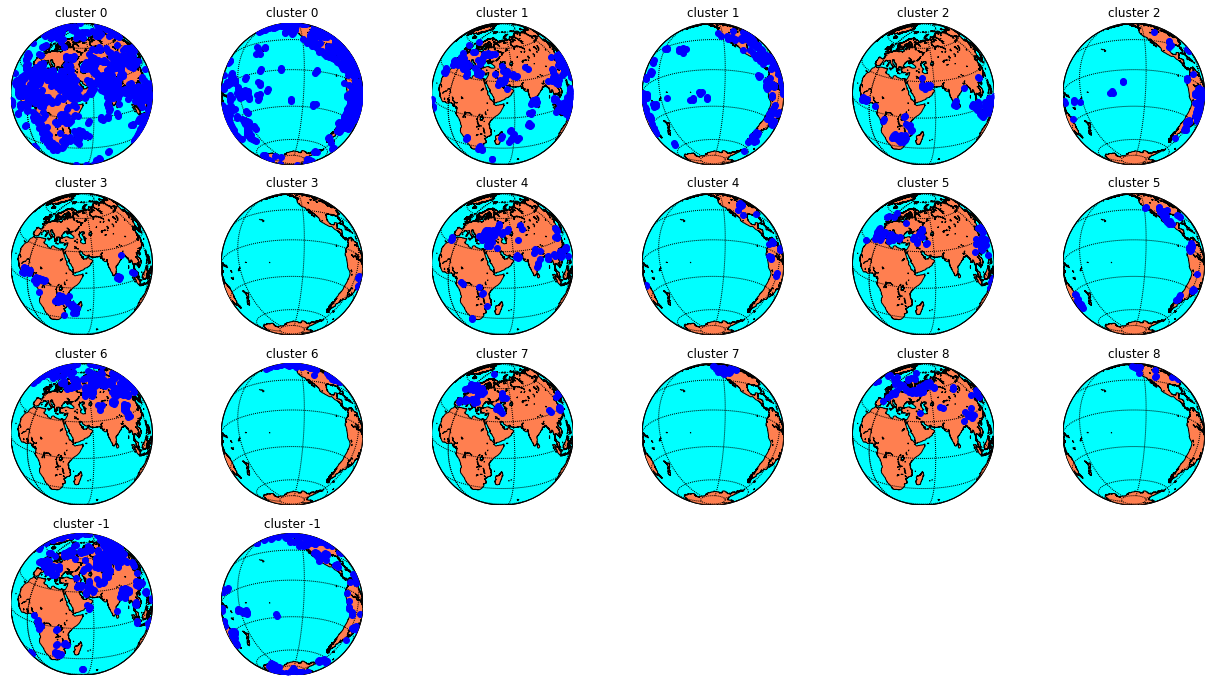

In [15]:
plt.figure(figsize=(22,12))
for j, i in enumerate(tot_clust):
    data_c = data.loc[labels==i]
    plt.subplot(4,6,2*j+1)
    plot_data(point_lon[data_c.point.values], point_lat[data_c.point.values],\
              50, 20, 'cluster '+str(i), 6)
    plt.subplot(4,6,2*j+2)
    plot_data(point_lon[data_c.point.values], point_lat[data_c.point.values],\
              230, -20, 'cluster '+str(i), 6)
plt.show()

#### We experience one cluster predominant in size. Also this approach do not generalize well. Let's go deeper and cluster on monthly averages.

In [110]:
monthLand2017 = prepLand2017.reset_index()

In [89]:
monthLand = prepLand.reset_index()

In [90]:
agg_dic = {col:'mean' for col in monthLand.columns}
temp = ['fog','rain_drizzle','snow_ice_pellets','hail','thunder','tornado_funnel_cloud']
for t in temp:
    agg_dic[t] = 'max'
temp = ['point','year','mo','da']
for t in temp:
    del agg_dic[t]
print(agg_dic)

{'wdsp_diff': 'mean', u'max': 'mean', u'wdsp': 'mean', u'temp': 'mean', u'min': 'mean', u'snow_ice_pellets': 'max', u'sndp': 'mean', u'tornado_funnel_cloud': 'max', u'hail': 'max', u'dewp': 'mean', 'temp_diff': 'mean', u'fog': 'max', u'thunder': 'max', u'prcp': 'mean', u'rain_drizzle': 'max'}


In [10]:
monthLand2017 = monthLand2017.groupby(['mo','point']).agg(agg_dic)

In [91]:
monthLand = monthLand.groupby(['mo','point']).agg(agg_dic)

#### Some months have no data. Let's get rid of point where more than 5 days are missing per month.

In [15]:
# This is about 5% of the data
monthLand2017 = monthLand2017.unstack(0)[(monthLand2017.unstack(0).isnull().mean(axis=1)<=(1/6))]

In [16]:
# Here I interpolate nan
monthLand2017 = monthLand2017.stack(0).interpolate(method='linear', axis=1,limit_direction='both').unstack(1)

In [92]:
(monthLand.unstack(0).isnull().mean(axis=1)<=(1/6)).mean()

0.94940152339499451

In [95]:
monthLand = monthLand.stack(0).drop(columns=['min','max']).unstack(1)
# monthLand.drop(columns=['min'])

### Let's try DBSCAN on the monthly data

In [27]:
from sklearn.cluster import DBSCAN, KMeans
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

db = DBSCAN(eps=20, min_samples=25).fit(monthLand)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

# print('Estimated number of clusters: %d' % n_clusters_)


In [28]:
n_clusters_

4

In [29]:
tot_clust = set(labels)
for i in tot_clust:
    print(sum(labels==i))

910
29
25
42
2484


This is even worse, we end up with a very concentrated clustering. Only two regions on the globe.

### Let's try KMeans on the monthly data

In [30]:
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

kmeans = KMeans(n_clusters=8, random_state=0).fit(monthLand)
labels = kmeans.labels_


In [31]:
tot_clust = set(labels)
for i in tot_clust:
    print(sum(labels==i))

229
54
1011
18
119
1933
93
33


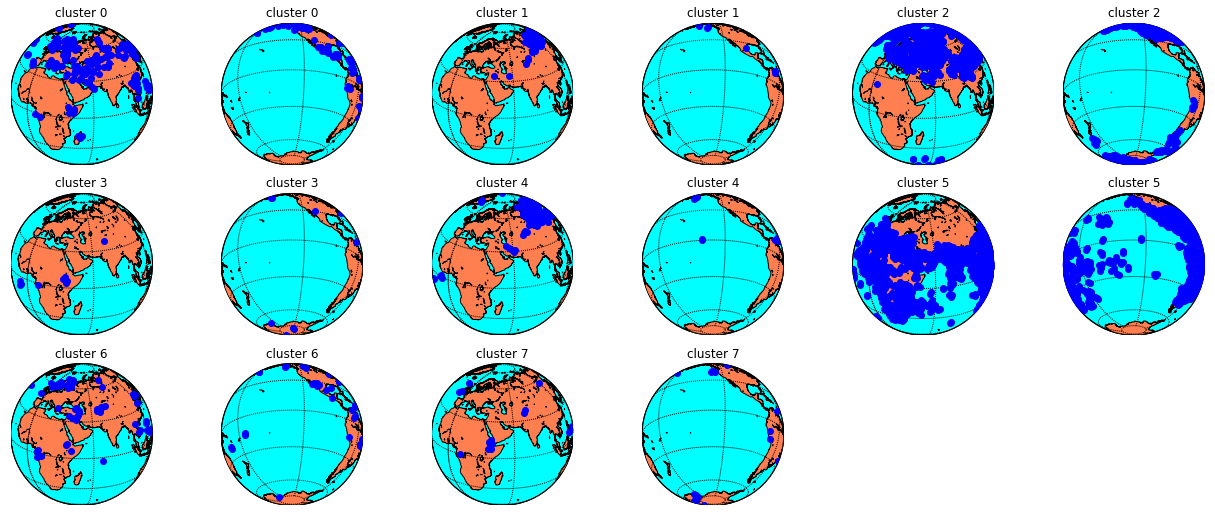

In [32]:
plt.figure(figsize=(22,12))
for j, i in enumerate(tot_clust):
    data_c = monthLand.loc[labels==i]
    plt.subplot(4,6,2*j+1)
    plot_data(point_lon[data_c.index], point_lat[data_c.index],\
              50, 20, 'cluster '+str(i), 6)
    plt.subplot(4,6,2*j+2)
    plot_data(point_lon[data_c.index], point_lat[data_c.index],\
              230, -20, 'cluster '+str(i), 6)
plt.show()

#### Better but still not usable as is yet. Let's normalize first.

In [96]:
from sklearn.cluster import DBSCAN, KMeans
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(monthLand)
kmeans = KMeans(n_clusters=8, random_state=0).fit(scaler.transform(monthLand))
labels = kmeans.labels_


In [97]:
tot_clust = set(labels)
print([sum(labels==i) for i in tot_clust])

[486, 626, 317, 373, 101, 647, 44, 896]


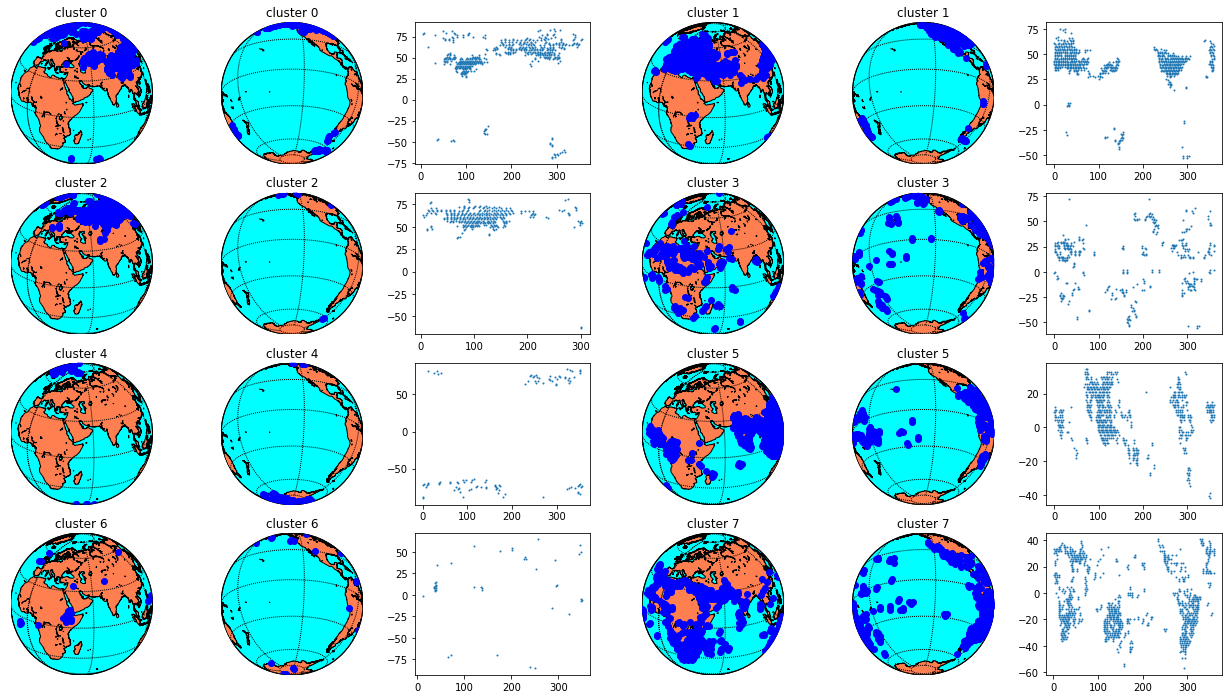

In [98]:
plt.figure(figsize=(22,12))
for j, i in enumerate(tot_clust):
    data_c = monthLand.loc[labels==i]
    plt.subplot(4,6,3*j+1)
    plot_data(point_lon[data_c.index], point_lat[data_c.index],\
              50, 20, 'cluster '+str(i), 6)
    plt.subplot(4,6,3*j+2)
    plot_data(point_lon[data_c.index], point_lat[data_c.index],\
              230, -20, 'cluster '+str(i), 6)
    plt.subplot(4,6,3*j+3)
    plt.scatter(point_lon[data_c.index], point_lat[data_c.index],s=1)
plt.show()

We can see on the maps that the clusters are coherent with our elementary geography training. 

In [36]:
scaler = StandardScaler()
scaler.fit(monthLand)
db = DBSCAN(eps=6, min_samples=40).fit(scaler.transform(monthLand))
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)


Estimated number of clusters: 4


### For peace of mind let's try HDBSCAN.

In [44]:
import hdbscan
clusterer = hdbscan.HDBSCAN()
clusterer.fit(scaler.transform(monthLand))

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_method='eom',
    core_dist_n_jobs=4, gen_min_span_tree=False, leaf_size=40,
    match_reference_implementation=False, memory=Memory(cachedir=None),
    metric='euclidean', min_cluster_size=5, min_samples=None, p=None,
    prediction_data=False)

In [45]:
clusterer.labels_.max()

46

In [46]:
tot_clust = set(clusterer.labels_)
print([sum(clusterer.labels_==i) for i in tot_clust])

[5, 5, 5, 8, 23, 6, 9, 8, 10, 5, 5, 7, 6, 6, 5, 5, 6, 6, 28, 6, 14, 5, 20, 20, 61, 33, 8, 7, 17, 9, 12, 8, 7, 6, 40, 5, 13, 14, 8, 5, 195, 28, 34, 6, 5, 83, 60, 2603]


This prove inconclusive... Too many and too small clusters.

### Let's print the time series for a random point on earth

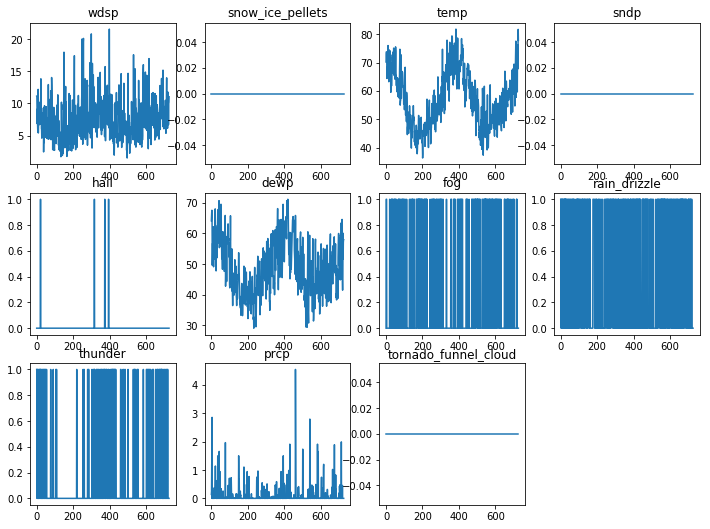

In [26]:
to_chart = prepLand[prepLand.point==1744].drop(['min','max','point'],axis=1)
num_plot = 1
plt.figure(figsize=(12,12))
for col in to_chart.columns:
    plt.subplot(4,4,num_plot)
    plt.title(col)
    plt.plot(to_chart[col].values)
    num_plot += 1
plt.show()

The seasonality is obvious in temperature and dew point. All that work to discover seasons!

### Now, let's look for anomalies

We will start with unsupervised anomaly detection. I've picked 3 standard anomaly detection algorithms a statistic model (Elliptic Envelop fits the tightest Gaussian (smallest volume ellipsoid) that it can), a tree based model (Isolation Forest work better with higher dimensionality) and a density based algorithm (Local Outlier Factor measurs the local deviation of a given data point with respect to its neighbours).

In [78]:
from sklearn import svm
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

In [99]:
prepLand[prepLand.point.isin(list(monthLand[labels==clust_i].index.values))].drop(['min','max','point'],axis=1).isna().sum()

wdsp                    0
snow_ice_pellets        0
temp                    0
sndp                    0
hail                    0
dewp                    0
fog                     0
rain_drizzle            0
thunder                 0
prcp                    0
tornado_funnel_cloud    0
wdsp_diff               0
temp_diff               0
dtype: int64

Let's apply those algorithm within each of the 8 clusters we identified earlier on.

In [100]:
# define outlier/anomaly detection methods to be compared
outliers_fraction = 0.05
anomaly_algorithms = [
    ("Robust covariance", EllipticEnvelope(contamination=outliers_fraction)),
#     ("One-Class SVM", svm.OneClassSVM(nu=outliers_fraction, kernel="rbf",
#                                       gamma=0.1)),
    ("Isolation Forest", IsolationForest(contamination=outliers_fraction,
                                         random_state=42)),
    ("Local Outlier Factor", LocalOutlierFactor(
        n_neighbors=35, contamination=outliers_fraction))]

outliers = {}
for clust_i in range(8):
    X = prepLand[prepLand.point.isin(list(monthLand[labels==clust_i].index.values))].drop(['min','max','point'],axis=1).values
    outliers[clust_i] = []
    # rng = np.random.RandomState(42)

    for name, algorithm in anomaly_algorithms:
        # fit the data and tag outliers
        if name == "Local Outlier Factor":
            y_pred = algorithm.fit_predict(X)
        else:
            y_pred = algorithm.fit(X).predict(X)
        print(name, sum(y_pred))
        outliers[clust_i].append(y_pred)

('Robust covariance', 317187)
('Isolation Forest', 317187)
('Local Outlier Factor', 317187)
('Robust covariance', 410821)
('Isolation Forest', 410821)
('Local Outlier Factor', 410821)
('Robust covariance', 207513)
('Isolation Forest', 207513)
('Local Outlier Factor', 207513)
('Robust covariance', 210139)
('Isolation Forest', 210135)
('Local Outlier Factor', 210133)


C:\Users\Julie\Anaconda3\envs\project3.6\lib\site-packages\sklearn\covariance\robust_covariance.py:622: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "


('Robust covariance', 62805)
('Isolation Forest', 62803)
('Local Outlier Factor', 62801)
('Robust covariance', 416840)
('Isolation Forest', 416838)
('Local Outlier Factor', 416840)
('Robust covariance', 23506)
('Isolation Forest', 23506)
('Local Outlier Factor', 23506)
('Robust covariance', 564898)
('Isolation Forest', 564898)
('Local Outlier Factor', 564898)


We can now use ensemble methode: we will only take into account anomalies which have been identified as an anomaly by all 3 methods.

For exemple, for the first cluster, we reduce the number of anomalies drasticaly as below:

In [111]:
print(sum(outliers[0][0]==-1), sum(outliers[0][1]==-1), sum(outliers[0][2]==-1))
sum((outliers[0][0]==-1) * (outliers[0][1]==-1) * (outliers[0][2]==-1))


(17622, 17622, 17622)


1534

Now I'm reducing further the universe by only looking at large anomaly. I define them as a day where more than 5 points on the mesh (within a cluster) are impacted by the anomaly.

cluster 0: 1534 anomalies
60 anomalies affecting a big area
Here are the cluster averages


,wdsp,snow_ice_pellets,temp,min,max,sndp,hail,dewp,fog,rain_drizzle,thunder,prcp,tornado_funnel_cloud,point,wdsp_diff,temp_diff
0,21.11628,0.322798,33.605794,25.04198,42.046996,2.011121,0.002162,22.566787,0.153871,0.336815,0.028003,0.055493,0.000077,7877.962625,0.008873,-0.012803


here are the first 20 large anomalies


wdsp  snow_ice_pellets       temp        min  \
year   mo  da                                                         
2016.0 1.0 15.0  271.730000          0.666667   0.355556  -7.840556   
           17.0  321.727945          0.700000  -5.127903 -14.693969   
           18.0  452.089167          0.666667 -17.995000 -25.225000   
           19.0  290.947222          0.555556 -16.820516 -27.063545   
           23.0  294.004337          0.285714  -7.295765 -20.026122   
           28.0  324.909647          0.333333 -12.953369 -21.424250   
           29.0  167.332681          0.571429 -21.809751 -32.838152   
           31.0  299.544165          0.428571  -5.911957 -18.471141   
       2.0 1.0   183.583929          0.571429  12.733333   5.490476   
           4.0   242.117143          0.857143  -9.001786 -15.140833   
           5.0   406.766889          0.333333   3.152917  -5.205722   
           6.0   358.781905          0.571429  -5.932857 -12.287381   
           9.0   352.208929          0.500000  -4.024643 -13.964881   
           10.0   99.129060          0.500000 -12.709915 -24.291197   
           13.0  371.187041          0.571429 -12.598741 -22.717857   
           15.0  312.315000          0.571429   1.416667  -7.190000   
           18.0  281.617347          0.857143  -4.384388 -11.663571   
           27.0  253.690000          0.500000  -5.488519 -15.945556   
           29.0  255.627083          0.333333  -8.830278 -20.351574   
       3.0 23.0  455.108509          0.714286  22.721032  15.333594   

                       max       sndp  hail       dewp       fog  \
year   mo  da                                                      
2016.0 1.0 15.0   9.081667   7.828333   0.0  -4.005556  0.333333   
           17.0   2.846386   2.074617   0.0 -10.046298  0.100000   
           18.0  -9.065833   8.566667   0.0 -23.628333  0.000000   
           19.0  -7.034471   8.186534   0.0 -23.923810  0.222222   
           23.0   0.872347   6.320833   0.0 -14.243878  0.428571   
           28.0  -3.598677   6.760494   0.0 -19.679409  0.111111   
           29.0  -9.379819   4.953656   0.0 -29.487840  0.285714   
           31.0   3.818812   4.673741   0.0 -12.408647  0.428571   
       2.0 1.0   18.900595  10.768367   0.0   8.538690  0.571429   
           4.0   -1.418214  11.871429   0.0 -15.386650  0.285714   
           5.0   12.919917   7.644444   0.0  -3.514611  0.333333   
           6.0   -0.204048   3.845238   0.0 -11.107381  0.142857   
           9.0    7.067381  10.444841   0.0  -9.608869  0.500000   
           10.0  -1.256966   8.839444   0.0 -18.934017  0.000000   
           13.0  -0.016327   6.499048   0.0 -18.363878  0.285714   
           15.0  12.257381   7.916667   0.0  -8.585952  0.285714   
           18.0   4.253980   7.995238   0.0 -11.059660  0.142857   
           27.0   5.304074   8.225000   0.0 -22.539444  0.000000   
           29.0   3.509583   9.409028   0.0 -16.849444  0.166667   
       3.0 23.0  31.657653   3.560714   0.0   7.487115  0.071429   

                 rain_drizzle  thunder      prcp  tornado_funnel_cloud  \
year   mo  da                                                            
2016.0 1.0 15.0      0.000000      0.0  0.504778                   0.0   
           17.0      0.100000      0.0  0.025223                   0.0   
           18.0      0.000000      0.0  0.000000                   0.0   
           19.0      0.000000      0.0  0.007017                   0.0   
           23.0      0.142857      0.0  0.001182                   0.0   
           28.0      0.000000      0.0  0.000794                   0.0   
           29.0      0.000000      0.0  0.014133                   0.0   
           31.0      0.285714      0.0  0.025934                   0.0   
       2.0 1.0       0.000000      0.0  0.008095                   0.0   
           4.0       0.142857      0.0  0.018690                   0.0   
           5.0       0.166667      0.0  0.112639                   0.0   
 

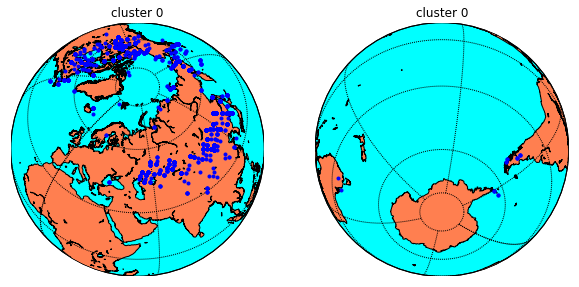

cluster 1: 2114 anomalies
144 anomalies affecting a big area
Here are the cluster averages


,wdsp,snow_ice_pellets,temp,min,max,sndp,hail,dewp,fog,rain_drizzle,thunder,prcp,tornado_funnel_cloud,point,wdsp_diff,temp_diff
0,33.663912,0.229659,54.328039,45.030184,63.785237,1.030822,0.023765,42.079056,0.417284,0.659274,0.199361,0.07054,0.001395,7400.792965,-0.003634,0.001299


here are the first 20 large anomalies


wdsp  snow_ice_pellets       temp        min  \
year   mo  da                                                         
2016.0 1.0 2.0     5.293239          0.666667  -5.606086 -16.386490   
           3.0   252.352709          1.000000   8.710065   2.568807   
           6.0   362.284006          0.666667  -0.251364  -6.726497   
           7.0   357.349533          0.875000  -3.545915 -11.783694   
           8.0   136.370847          0.777778   5.920443  -0.291165   
           9.0   254.540249          0.727273  -6.056723 -12.903929   
           10.0  170.994353          1.000000  -6.890389 -14.732688   
           11.0  169.409354          0.714286  -3.367360 -11.287402   
           13.0   54.211607          1.000000  12.744530   1.192520   
           14.0  113.906648          0.857143  15.615281   7.944292   
           15.0  218.864582          1.000000   9.652980   0.025109   
           16.0  170.113685          1.000000  -1.664126 -10.343723   
           17.0  101.367482          1.000000   4.874650  -7.078651   
           18.0  175.191584          0.750000   5.440356  -3.006110   
           19.0  190.263464          0.700000  -5.911755 -14.483427   
           20.0  170.226982          0.545455  -1.270657  -9.632158   
           21.0  222.169633          0.928571  -1.817497  -9.345622   
           22.0  254.413416          0.909091   4.146291  -6.302255   
           23.0  154.556968          0.952381  13.501225   3.190817   
           24.0  157.358178          1.000000   9.289213   2.347361   

                       max       sndp      hail       dewp       fog  \
year   mo  da                                                          
2016.0 1.0 2.0    1.214043   9.420962  0.000000  -9.823438  0.000000   
           3.0   14.352629   7.808304  0.000000   1.843427  0.333333   
           6.0    7.280525   6.466483  0.000000  -5.688177  0.111111   
           7.0    4.054254   7.036183  0.000000  -8.529732  0.125000   
           8.0   12.409365   7.791887  0.000000   0.919129  0.333333   
           9.0   -0.072139   8.376064  0.000000 -10.974959  0.181818   
           10.0  -0.936440   8.511609  0.000000 -11.867174  0.100000   
           11.0   3.628138   7.593631  0.000000  -8.303200  0.000000   
           13.0  18.688023  12.212097  0.000000   7.569816  0.250000   
           14.0  21.323426  12.423476  0.000000  11.618529  0.714286   
           15.0  19.463028   9.648586  0.000000   5.774911  0.714286   
           16.0   5.906245   9.649121  0.000000  -5.661479  0.461538   
           17.0  11.254474  13.323791  0.000000   0.761884  0.250000   
           18.0  12.462528  11.718301  0.166667   0.509994  0.333333   
           19.0   1.349538  14.052790  0.000000 -10.746614  0.100000   
           20.0   5.969722   9.391252  0.000000  -7.631816  0.454545   
           21.0   4.584154  10.689687  0.000000  -5.759501  0.642857   
           22.0  12.062042  11.203036  0.000000   0.617907  0.727273   
           23.0  21.073916  15.021584  0.000000   6.320865  0.523810   
           24.0  13.970439  19.249024  0.000000   4.586322  0.285714   

                 rain_drizzle   thunder      prcp  tornado_funnel_cloud  \
year   mo  da                                                             
2016.0 1.0 2.0       0.166667  0.000000  0.002855                   0.0   
           3.0       0.500000  0.000000  0.024423                   0.0   
           6.0       0.111111  0.000000  0.011980                   0.0   
           7.0       0.000000  0.000000  0.005879                   0.0   
           8.0       0.222222  0.111111  0.044852                   0.0   
           9.0       0.090909  0.000000  0.013808                   0.0   
           10.0      0.000000  0.000000  0.012566                   0.0   
           11.0      0.142857  0.000000  0.008652                   0.0   
           13.0      0.250000  0.000000  0.235007                   0.0   
           14.0      0.428571  0.142857  0.129865 

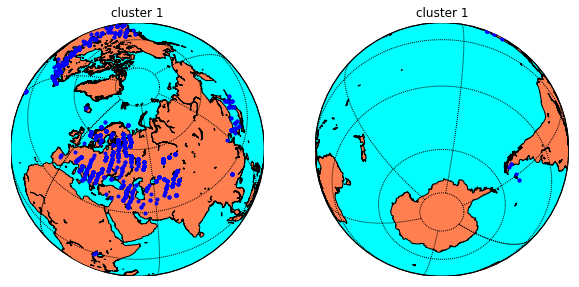

cluster 2: 704 anomalies
18 anomalies affecting a big area
Here are the cluster averages


,wdsp,snow_ice_pellets,temp,min,max,sndp,hail,dewp,fog,rain_drizzle,thunder,prcp,tornado_funnel_cloud,point,wdsp_diff,temp_diff
0,109.494303,0.477267,26.911201,17.385726,35.357637,8.106436,0.014638,18.846464,0.215469,0.378977,0.066478,0.050383,0.000278,8557.533914,-0.049238,0.006826


here are the first 20 large anomalies


wdsp  snow_ice_pellets       temp        min  \
year   mo   da                                                         
2016.0 1.0  14.0  618.508690          0.714286  -4.722738 -13.676548   
            17.0  618.008163          0.285714 -36.241071 -43.046429   
       2.0  12.0  774.187222          0.666667 -19.397222 -27.573889   
            21.0  729.589822          0.500000  -8.965894 -16.832819   
       3.0  23.0  753.504422          0.571429  15.975680   9.864966   
       12.0 4.0   751.222917          0.750000 -33.154167 -39.909375   
            23.0  560.510714          0.833333 -32.403108 -44.723796   
2017.0 1.0  4.0   773.259470          0.500000 -31.679924 -40.625379   
            5.0   313.416667          0.285714 -31.216667 -41.340476   
            6.0   789.150238          0.571429 -48.356667 -52.407619   
            8.0   464.281250          0.750000 -28.416667 -38.475000   
            26.0  916.836111          0.333333 -34.968056 -41.729167   
            27.0  719.415625          0.500000 -37.400000 -44.653125   
            29.0  776.652381          0.333333 -41.238095 -48.943810   
       2.0  1.0   533.021875          0.375000 -47.146875 -55.737500   
            2.0   336.937037          0.888889 -28.564815 -41.583333   
       12.0 22.0  893.088095          0.666667 -39.578571 -44.404762   
            23.0  494.852273          0.714286 -47.373701 -51.579221   

                        max       sndp  hail       dewp       fog  \
year   mo   da                                                      
2016.0 1.0  14.0   3.677262  16.716667   0.0  -8.080952  0.142857   
            17.0 -24.741327  18.114626   0.0 -41.965051  0.285714   
       2.0  12.0 -11.914444  23.096667   0.0 -24.446667  0.000000   
            21.0   2.614211  30.540833   0.0 -14.454037  0.166667   
       3.0  23.0  25.620748   7.814286   0.0  10.094218  0.000000   
       12.0 4.0  -27.797917  11.263542   0.0 -37.663542  0.125000   
            23.0 -20.640767  15.258148   0.0 -38.127910  0.500000   
2017.0 1.0  4.0  -20.466667  21.766667   0.0 -36.865909  0.333333   
            5.0  -21.071429  20.842857   0.0 -36.542857  0.000000   
            6.0  -43.080238  14.584524   0.0 -55.100238  0.142857   
            8.0  -20.312500  21.275000   0.0 -33.562500  0.125000   
            26.0 -27.802778  30.241667   0.0 -41.219444  0.000000   
            27.0 -29.967187  19.633333   0.0 -43.818750  0.125000   
            29.0 -34.069762  27.548571   0.0 -48.627381  0.000000   
       2.0  1.0  -36.012500  20.950000   0.0 -53.646875  0.125000   
            2.0  -20.783333  29.307407   0.0 -34.603704  0.000000   
       12.0 22.0 -33.863095  17.984524   0.0 -45.740476  0.166667   
            23.0 -42.730844  19.869286   0.0 -53.733766  0.142857   

                  rain_drizzle  thunder      prcp  tornado_funnel_cloud  \
year   mo   da                                                            
2016.0 1.0  14.0      0.285714      0.0  0.389810                   0.0   
            17.0      0.000000      0.0  0.002806                   0.0   
       2.0  12.0      0.000000      0.0  0.171667                   0.0   
            21.0      0.166667      0.0  0.108987                   0.0   
       3.0  23.0      0.000000      0.0  0.200357                   0.0   
       12.0 4.0       0.000000      0.0  0.022500                   0.0   
            23.0      0.000000      0.0  0.014222                   0.0   
2017.0 1.0  4.0       0.000000      0.0  0.038447                   0.0   
            5.0       0.285714      0.0  0.121667                   0.0   
            6.0       0.000000      0.0  0.000952                   0.0   
            8.0       0.000000      0.0  0.148958                   0.0   
            26.0      0.166667      0.0  0.003750                   0.0   
            27.0      0.000000      0.0  0.001429                   0.0   
            29.0      0.000000      0.0  0.000833                   0.0   
  

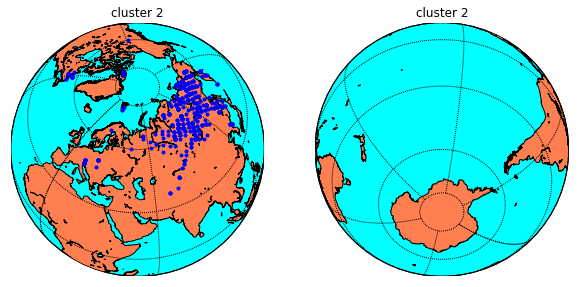

cluster 3: 968 anomalies
20 anomalies affecting a big area
Here are the cluster averages


,wdsp,snow_ice_pellets,temp,min,max,sndp,hail,dewp,fog,rain_drizzle,thunder,prcp,tornado_funnel_cloud,point,wdsp_diff,temp_diff
0,26.299955,0.000844,70.951104,64.294788,77.543714,0.003514,0.000069,51.182519,0.004326,0.012026,0.007529,0.022403,0.000026,5448.565381,0.010186,-0.000525


here are the first 20 large anomalies


wdsp  snow_ice_pellets       temp        min  \
year   mo   da                                                         
2016.0 1.0  31.0  235.492308          0.000000  73.153846  65.923077   
       5.0  8.0    12.242857          0.000000  64.085714  56.767857   
            23.0   15.433333          0.000000  64.933333  60.100000   
            24.0   14.228571          0.000000  69.157143  62.414286   
       7.0  22.0   11.500000          0.000000  81.461905  75.180952   
       8.0  7.0     7.109524          0.000000  80.919048  75.676190   
            8.0   172.350000          0.000000  79.191667  75.075000   
            24.0   12.977778          0.000000  82.105556  74.794444   
            25.0  152.395238          0.000000  79.395238  74.690476   
            26.0   10.283333          0.000000  79.183333  75.144444   
2017.0 2.0  3.0    13.534524          0.428571  52.454286  44.602857   
            18.0  105.676667          0.200000  61.653333  54.666667   
       3.0  31.0   15.228571          0.000000  60.907143  52.350000   
       4.0  5.0    10.363889          0.000000  64.166667  59.033333   
       5.0  27.0    6.883333          0.000000  77.783333  72.966667   
       6.0  7.0    11.714286          0.000000  66.657143  63.257143   
            9.0    11.725000          0.000000  71.325000  65.387500   
       9.0  27.0    7.947619          0.000000  67.133333  61.623810   
       11.0 2.0    14.428571          0.000000  77.628571  72.642857   
       12.0 24.0   13.850000          0.000000  65.964286  60.321429   

                        max      sndp  hail       dewp       fog  \
year   mo   da                                                     
2016.0 1.0  31.0  82.330769  0.000000   0.0  41.558373  0.000000   
       5.0  8.0   71.307143  0.000000   0.0  59.733333  0.000000   
            23.0  70.733333  0.000000   0.0  42.200000  0.000000   
            24.0  74.928571  0.000000   0.0  52.100000  0.000000   
       7.0  22.0  88.138095  0.000000   0.0  74.795238  0.000000   
       8.0  7.0   86.685714  0.000000   0.0  77.371429  0.000000   
            8.0   84.033333  0.000000   0.0  71.872714  0.000000   
            24.0  88.961111  0.000000   0.0  73.866667  0.000000   
            25.0  84.166667  0.000000   0.0  72.402802  0.000000   
            26.0  83.172222  0.000000   0.0  77.144444  0.000000   
2017.0 2.0  3.0   59.650476  1.114286   0.0  34.589524  0.142857   
            18.0  67.670000  0.000000   0.0  53.895251  0.100000   
       3.0  31.0  68.700000  0.000000   0.0  56.967025  0.000000   
       4.0  5.0   69.569444  8.000000   0.0  55.858751  0.000000   
       5.0  27.0  83.466667  0.000000   0.0  72.683333  0.000000   
       6.0  7.0   70.071429  0.000000   0.0  63.314286  0.000000   
            9.0   80.700000  0.000000   0.0  57.718750  0.000000   
       9.0  27.0  76.285714  0.000000   0.0  61.328571  0.000000   
       11.0 2.0   81.771429  0.000000   0.0  71.528571  0.000000   
       12.0 24.0  73.464286  0.000000   0.0  61.414286  0.000000   

                  rain_drizzle   thunder      prcp  tornado_funnel_cloud  \
year   mo   da                                                             
2016.0 1.0  31.0      0.000000  0.000000  0.147692                   0.0   
       5.0  8.0       0.000000  0.000000  1.378214                   0.0   
            23.0      0.000000  0.000000  0.930000                   0.0   
            24.0      0.000000  0.142857  1.318571                   0.0   
       7.0  22.0      0.285714  0.285714  2.331905                   0.0   
       8.0  7.0       0.428571  0.285714  1.530476                   0.0   
            8.0       0.166667  0.000000  1.310000                   0.0   
            24.0      0.444444  0.000000  0.925556                   0.0   
            25.0      0.714286  0.142857  0.520000                   0.0   
            26.0      1.000000  0.333333  1.437222                   0.0   
2017.0 2.0  3.0       0.571429

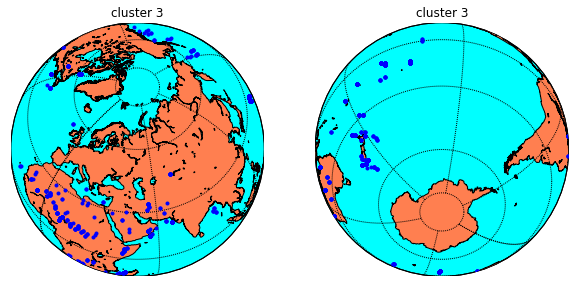

cluster 4: 165 anomalies
0 anomalies affecting a big area
Here are the cluster averages


,wdsp,snow_ice_pellets,temp,min,max,sndp,hail,dewp,fog,rain_drizzle,thunder,prcp,tornado_funnel_cloud,point,wdsp_diff,temp_diff
0,46.43018,0.114982,-3.84937,-9.661516,1.81621,1.44385,0.0,12.320603,0.015949,0.001548,0.0001,0.006313,0.000043,3783.40245,0.046287,-0.003237


here are the first 20 large anomalies


,,,wdsp,snow_ice_pellets,temp,min,max,sndp,hail,dewp,fog,rain_drizzle,thunder,prcp,tornado_funnel_cloud,point,wdsp_diff,temp_diff
year,mo,da,,,,,,,,,,,,,,,,


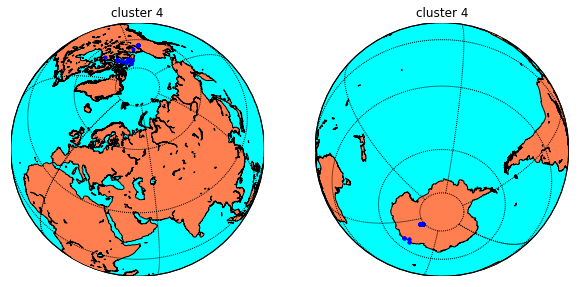

cluster 5: 2330 anomalies
110 anomalies affecting a big area
Here are the cluster averages


,wdsp,snow_ice_pellets,temp,min,max,sndp,hail,dewp,fog,rain_drizzle,thunder,prcp,tornado_funnel_cloud,point,wdsp_diff,temp_diff
0,18.294702,0.003863,79.166603,71.857608,86.818253,0.001726,0.005406,70.236206,0.138444,0.58466,0.299312,0.199691,0.001669,5191.487777,-0.007432,-0.001502


here are the first 20 large anomalies


wdsp  snow_ice_pellets       temp        min  \
year   mo  da                                                         
2016.0 1.0 2.0   314.605635          0.000000  67.700415  60.892235   
           3.0   214.669386          0.000000  63.287483  54.851971   
           4.0   315.921545          0.000000  69.156576  63.260864   
           5.0   249.280986          0.000000  70.743550  62.729319   
           6.0   247.037479          0.000000  66.696348  56.118087   
           7.0   264.193002          0.000000  69.499431  60.907523   
           15.0  286.714405          0.000000  60.576071  47.982143   
           16.0  228.662443          0.000000  71.427484  60.853595   
           17.0  202.480912          0.000000  69.291140  60.545107   
           18.0  303.447897          0.000000  72.083056  61.013929   
           20.0  412.386749          0.000000  75.559716  69.858416   
           21.0  339.362877          0.000000  79.674694  69.375890   
           24.0  384.223135          0.285714  67.840278  57.786270   
           25.0  389.355151          0.307692  60.410758  51.116404   
           26.0  263.572058          0.000000  45.478423  38.819273   
           27.0  235.537780          0.000000  58.185946  47.918389   
           29.0  228.788625          0.000000  66.503834  57.086914   
       2.0 4.0   203.548277          0.000000  66.638554  58.450953   
           5.0   151.501665          0.125000  57.577713  45.855525   
           9.0   316.897853          0.000000  67.480502  55.353624   

                       max      sndp   hail       dewp       fog  \
year   mo  da                                                      
2016.0 1.0 2.0   74.643609  0.000000  0.000  59.786068  0.800000   
           3.0   72.550911  0.000000  0.000  55.788802  0.857143   
           4.0   77.393076  0.000000  0.000  63.986773  0.700000   
           5.0   79.478868  0.000000  0.000  63.785251  0.666667   
           6.0   76.537743  0.000000  0.000  55.769623  0.666667   
           7.0   80.821825  0.000000  0.000  61.830992  0.666667   
           15.0  72.270357  0.000000  0.000  48.416190  0.857143   
           16.0  82.491256  0.000000  0.000  59.510228  0.777778   
           17.0  79.308892  0.000000  0.000  59.476229  0.833333   
           18.0  80.935754  0.000000  0.000  58.550283  0.428571   
           20.0  81.538929  0.000000  0.000  68.003874  0.714286   
           21.0  88.314117  0.000000  0.000  67.965698  0.444444   
           24.0  76.262579  0.000000  0.000  52.877460  0.142857   
           25.0  68.425478  0.030769  0.000  47.961059  0.076923   
           26.0  50.357401  0.000000  0.000  36.838372  0.266667   
           27.0  67.581138  0.000000  0.125  50.530962  0.500000   
           29.0  76.922808  0.000000  0.000  58.173234  0.285714   
       2.0 4.0   74.291262  0.000000  0.000  55.761624  0.600000   
           5.0   67.838014  0.000000  0.000  44.421792  0.750000   
           9.0   78.011058  0.000000  0.000  53.341587  0.250000   

                 rain_drizzle   thunder      prcp  tornado_funnel_cloud  \
year   mo  da                                                             
2016.0 1.0 2.0       0.700000  0.000000  0.047741                   0.0   
           3.0       0.285714  0.000000  0.010703                   0.0   
           4.0       0.700000  0.000000  0.131270                   0.0   
           5.0       0.500000  0.333333  0.299965                   0.0   
           6.0       0.333333  0.000000  0.001492                   0.0   
           7.0       0.222222  0.000000  0.060307                   0.0   
           15.0      0.285714  0.000000  0.202429                   0.0   
           16.0      0.222222  0.000000  0.123940                   0.0   
           17.0      0.666667  0.000000  0.024343                   0.0   
           18.0      0.142857  0.000000  0.000349                   0.0   
           20.0      0.714286  0.000000  0.105095              

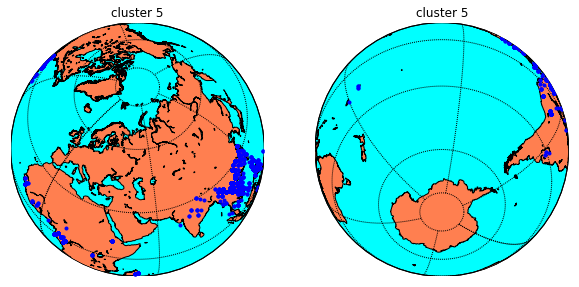

cluster 6: 28 anomalies
0 anomalies affecting a big area
Here are the cluster averages


,wdsp,snow_ice_pellets,temp,min,max,sndp,hail,dewp,fog,rain_drizzle,thunder,prcp,tornado_funnel_cloud,point,wdsp_diff,temp_diff
0,573.502528,0.027605,55.460896,48.472959,61.361582,0.238564,0.001187,47.94172,0.042614,0.125852,0.06842,0.046651,0.000191,5441.954859,0.174624,-0.001337


here are the first 20 large anomalies


,,,wdsp,snow_ice_pellets,temp,min,max,sndp,hail,dewp,fog,rain_drizzle,thunder,prcp,tornado_funnel_cloud,point,wdsp_diff,temp_diff
year,mo,da,,,,,,,,,,,,,,,,


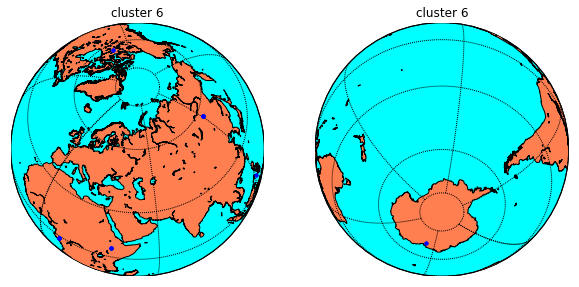

cluster 7: 4877 anomalies
356 anomalies affecting a big area
Here are the cluster averages


,wdsp,snow_ice_pellets,temp,min,max,sndp,hail,dewp,fog,rain_drizzle,thunder,prcp,tornado_funnel_cloud,point,wdsp_diff,temp_diff
0,15.483015,0.00459,73.77676,64.370463,83.316041,0.00297,0.001405,57.877104,0.075387,0.29931,0.101036,0.052931,0.000127,4213.527451,0.010166,-0.000996


here are the first 20 large anomalies


wdsp  snow_ice_pellets       temp        min  \
year   mo  da                                                         
2016.0 1.0 1.0    42.677778          0.111111  74.031481  66.577778   
           2.0    86.591159          0.000000  72.257141  65.841989   
           3.0    55.724621          0.071429  69.014655  62.373395   
           4.0    98.534983          0.117647  71.538394  65.060382   
           5.0   168.060606          0.000000  70.832197  63.610606   
           6.0   108.585108          0.000000  71.772193  64.727896   
           7.0   130.765385          0.000000  71.033365  65.916250   
           8.0    58.384606          0.000000  69.902515  63.729939   
           9.0    62.240276          0.100000  72.442171  64.561111   
           10.0  181.892857          0.000000  69.367857  60.542857   
           11.0   82.277083          0.000000  73.418750  67.201563   
           12.0   56.019815          0.000000  69.329676  61.357176   
           13.0  135.063750          0.000000  71.741458  61.365972   
           14.0  163.200222          0.200000  74.455145  66.773248   
           15.0  219.816185          0.071429  68.363791  60.337499   
           16.0    5.668320          0.000000  76.072288  69.928968   
           18.0  142.195812          0.000000  71.375798  63.705698   
           19.0   75.501389          0.000000  73.506389  63.866944   
           20.0   70.762292          0.000000  76.060208  69.652708   
           21.0   45.262222          0.000000  73.516944  67.870278   

                       max      sndp      hail       dewp       fog  \
year   mo  da                                                         
2016.0 1.0 1.0   83.988889  0.000000  0.000000  68.003704  0.222222   
           2.0   79.771974  0.000000  0.066667  64.908764  0.400000   
           3.0   77.859515  0.000000  0.000000  62.467585  0.214286   
           4.0   79.132138  0.000000  0.000000  65.020784  0.411765   
           5.0   79.147727  0.000000  0.000000  62.030682  0.000000   
           6.0   82.458826  0.000000  0.000000  63.684354  0.222222   
           7.0   77.048365  0.000000  0.000000  64.146250  0.100000   
           8.0   78.143242  0.000000  0.100000  65.404182  0.100000   
           9.0   84.203205  0.200000  0.100000  64.646876  0.200000   
           10.0  79.589286  0.171429  0.000000  59.392857  0.142857   
           11.0  80.753125  0.000000  0.000000  68.275521  0.250000   
           12.0  75.853287  0.000000  0.000000  63.620787  0.111111   
           13.0  82.432014  0.000000  0.000000  61.830694  0.250000   
           14.0  82.036564  0.000000  0.000000  63.465111  0.266667   
           15.0  77.557971  0.000000  0.000000  60.430693  0.285714   
           16.0  84.489021  0.000000  0.000000  69.456415  0.500000   
           18.0  80.510171  0.000000  0.000000  63.001781  0.333333   
           19.0  82.761667  0.000000  0.000000  62.393889  0.250000   
           20.0  83.217083  0.000000  0.000000  69.558750  0.500000   
           21.0  81.381389  0.000000  0.000000  67.720556  0.083333   

                 rain_drizzle   thunder      prcp  tornado_funnel_cloud  \
year   mo  da                                                             
2016.0 1.0 1.0       0.777778  0.555556  1.916852                   0.0   
           2.0       0.733333  0.333333  1.044504                   0.0   
           3.0       0.857143  0.571429  1.215838                   0.0   
           4.0       0.882353  0.352941  1.411911                   0.0   
           5.0       0.454545  0.545455  1.684113                   0.0   
           6.0       0.833333  0.444444  1.770995                   0.0   
           7.0       0.800000  0.300000  1.233750                   0.0   
           8.0       1.000000  0.700000  1.323429                   0.0   
           9.0       0.700000  0.900000  1.527391                   0.0   
           10.0      0.571429  0.285714  1.130714                   0.0 

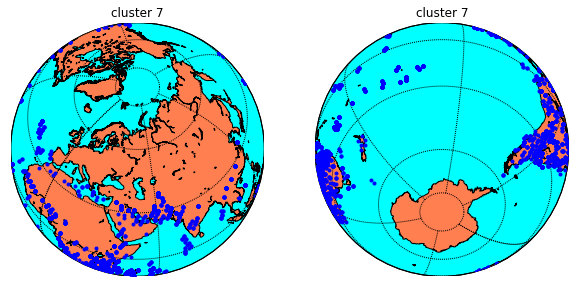

In [162]:
for clust_i in range(8):
    X = prepLand[prepLand.point.isin(list(monthLand[labels==clust_i].index.values))]
    Y = X[(outliers[clust_i][0]==-1) * (outliers[clust_i][1]==-1) * (outliers[clust_i][2]==-1)]
    print('cluster {}: {} anomalies'.format(clust_i,sum((outliers[clust_i][0]==-1) * (outliers[clust_i][1]==-1) * (outliers[clust_i][2]==-1))))
    print('{} anomalies affecting a big area'.format(sum(Y.groupby(['year','mo','da']).temp.count()>5)))
    print('Here are the cluster averages')
    display(pd.DataFrame(X.mean()).T)
    print('here are the first 20 large anomalies')
    display(Y.groupby(['year','mo','da']).agg('mean').loc[Y.groupby(['year','mo','da']).temp.count()>5].head(20))
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plot_data(point_lon[Y.point], point_lat[Y.point],\
              50, 60, 'cluster '+str(clust_i), 3)
    plt.subplot(1,2,2)
    plot_data(point_lon[Y.point], point_lat[Y.point],\
              230, -60, 'cluster '+str(clust_i), 3)
    plt.show()

In [116]:
outliers_df = pd.DataFrame(outliers).T

In [120]:
labels_df = pd.DataFrame(labels)

In [118]:
# outliers_df.to_hdf(PATH_DATA + 'outliers.h5',key='outliers',mode='w')

C:\Users\Julie\Anaconda3\envs\project3.6\lib\site-packages\pandas\core\generic.py:1996: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->[0L, 1L, 2L]]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [7]:
outliers_df = pd.read_hdf(PATH_DATA + 'outliers.h5')

In [122]:
# labels_df.to_hdf(PATH_DATA + 'labels.h5',key='labels',mode='w')

In [7]:
labels_df = pd.read_hdf(PATH_DATA + 'labels.h5')

A follow up on this approach would be to look at a single point on the mesh.

For this point we can check the averages and the anomalies found.

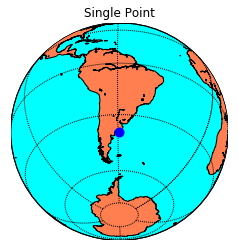

,wdsp,snow_ice_pellets,temp,min,max,sndp,hail,dewp,fog,rain_drizzle,thunder,prcp,tornado_funnel_cloud,point
0,7.625366,0.0,57.53924,47.388713,69.98228,0.0,0.005495,49.191735,0.287088,0.445055,0.166209,0.122974,0.0,1744.0


,year,mo,da,wdsp,snow_ice_pellets,temp,min,max,sndp,hail,dewp,fog,rain_drizzle,thunder,prcp,tornado_funnel_cloud,point
150,2016.0,5.0,30.0,18.0,0.0,54.80,52.90,57.20,0.0,0.0,53.70,0.0,1.0,0.0,1.500,0.0,1744
502,2017.0,5.0,19.0,14.7,0.0,60.75,51.65,64.20,0.0,0.0,58.75,0.0,1.0,1.0,1.735,0.0,1744
541,2017.0,6.0,27.0,15.4,0.0,53.40,49.45,66.30,0.0,0.0,52.25,0.0,1.0,1.0,2.795,0.0,1744
617,2017.0,9.0,11.0,17.0,0.0,53.40,49.35,57.55,0.0,0.0,49.00,1.0,1.0,1.0,1.200,0.0,1744


In [78]:
plot_data(point_lon[1744], point_lat[1744], point_lon[1744], point_lat[1744], 'Single Point',marker_size=9)
plt.show()
display(pd.DataFrame(prepLand[prepLand.point==1744].mean(axis=0)).T)
A = set(prepLand[prepLand.point==1744].reset_index().loc[results[0]==-1].index)
A = A.intersection(prepLand[prepLand.point==1744].reset_index().loc[results[2]==-1].index).intersection(prepLand[prepLand.point==1744].reset_index().loc[results[3]==-1].index)
prepLand[prepLand.point==1744].reset_index().iloc[sorted(list(A)),:]

## Let's load Hurricane data now

In [100]:
# list(hurricanes_head.columns)

In [102]:
hurricanes_features = ['sid', 'season', 'number', 'basin', 'subbasin', 'name', 'iso_time', 'latitude', 'longitude']

In [101]:
# hurricanes_schema

In [106]:
query3 ='SELECT ' + ', '.join(hurricanes_features) + ' FROM `bigquery-public-data.noaa_hurricanes.hurricanes`'
print(query3)

SELECT sid, season, number, basin, subbasin, name, iso_time, latitude, longitude FROM `bigquery-public-data.noaa_hurricanes.hurricanes`


In [108]:
%%time
bq_hurricanes_asstnt.estimate_query_size(query3)

Wall time: 749 ms


0

In [110]:
hurricanes = bq_hurricanes_asstnt.query_to_pandas_safe(query3)

In [126]:
# hurricanes.to_hdf(PATH_DATA + 'hurricanes.h5', key='hurricanes', mode='w')

In [171]:
hurricanes = pd.read_hdf(PATH_DATA + 'hurricanes.h5')

Let's get familiar with the hurricane data.

In [174]:
hurricanes.iso_time

0        1842-10-30 03:00:00+00:00
1        1842-11-01 15:00:00+00:00
2        1842-10-27 15:00:00+00:00
3        1842-10-28 15:00:00+00:00
4        1842-11-02 03:00:00+00:00
5        1842-10-29 03:00:00+00:00
6        1842-10-29 15:00:00+00:00
7        1842-10-28 03:00:00+00:00
8        1842-10-31 15:00:00+00:00
9        1842-10-26 15:00:00+00:00
10       1842-10-26 03:00:00+00:00
11       1842-11-01 03:00:00+00:00
12       1842-10-27 03:00:00+00:00
13       1842-10-30 15:00:00+00:00
14       1842-10-31 03:00:00+00:00
15       1842-10-26 09:00:00+00:00
16       1842-11-01 21:00:00+00:00
17       1842-10-29 21:00:00+00:00
18       1842-10-29 12:00:00+00:00
19       1842-10-31 12:00:00+00:00
20       1842-10-30 00:00:00+00:00
21       1842-10-27 09:00:00+00:00
22       1842-10-30 21:00:00+00:00
23       1842-11-01 00:00:00+00:00
24       1842-10-26 00:00:00+00:00
25       1842-10-27 21:00:00+00:00
26       1842-10-27 18:00:00+00:00
27       1842-10-28 21:00:00+00:00
28       1842-10-29 

## What about some visualization?
Let's look at the hurricanes on the globe. Here I'm only looking at hurricanes in 2016 and 2017. The larger point gives us the starting coordinates of the hurricane. As for the color, they show the time. The oldest are blue and the more recent are red.

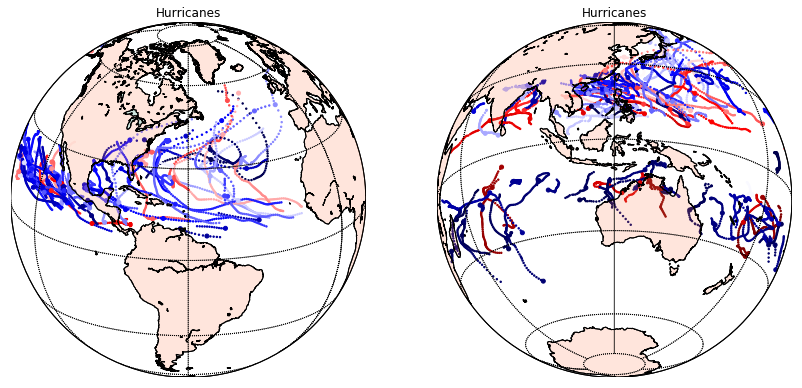

In [171]:
plt.figure(figsize=(14,7))
hurri_1617 = hurricanes.loc[hurricanes.season.isin(['2016', '2017'])]
hurri_1617_first = hurri_1617[hurri_1617.number.diff()!=0]
plt.subplot(1,2,1)
plot_data(hurri_1617.longitude.values, hurri_1617.latitude.values, -60, 20, 'Hurricanes',marker_size=2,list_val=hurri_1617.number.values)
plot_data(hurri_1617_first.longitude.values, hurri_1617_first.latitude.values, -60, 20, 'Hurricanes',marker_size=16,list_val=hurri_1617_first.number.values)
plt.subplot(1,2,2)
plot_data(hurri_1617.longitude.values, hurri_1617.latitude.values, 120, -20, 'Hurricanes',marker_size=2,list_val=hurri_1617.number.values)
plot_data(hurri_1617_first.longitude.values, hurri_1617_first.latitude.values, 120, -20, 'Hurricanes',marker_size=16,list_val=hurri_1617_first.number.values)

In [172]:
from pandas import Timestamp
hurri_1617['date'] = hurri_1617.iso_time.map(Timestamp.date)

C:\Users\Julie\Anaconda3\envs\project3.6\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


How many hurricane did we experience during those two years?

In [173]:
hurri_1617_first.shape

(242, 9)

## Placing hurricanes on our mesh
We want to identify the first day of an hurricane only. Indeed if we were to look for any day of the hurricane, our best indication would be: was it a hurricane yesterday?

Let's match those first day to locations on our mapping of the globe.

In [174]:
my_tree2 = BallTree(hurri_1617[['latitude','longitude']].values, metric = great_circle_kmeter, leaf_size=2)

In [175]:
## Getting stations within 1.25 radius from center (create overlap to cover all globe)
hurri_neighbors = my_tree2.query_radius(zip(map_lat,map_lon),dist_layers/2*1.25)

In [184]:
hurri_neighb_df = pd.DataFrame(hurri_neighbors)

In [185]:
# hurri_neighb_df.to_hdf(PATH_DATA + 'hurri_neighb_df.h5', key='hurri_neighb_df', mode='w')

C:\Users\Julie\Anaconda3\envs\project3.6\lib\site-packages\pandas\core\generic.py:1996: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->[0L]]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [170]:
hurri_neighb_df = pd.read_hdf(PATH_DATA + 'hurri_neighb_df.h5')

In [182]:
# hurri_1617.to_hdf(PATH_DATA + 'hurri_1617.h5', key='hurri_1617', mode='w')

C:\Users\Julie\Anaconda3\envs\project3.6\lib\site-packages\pandas\io\pytables.py:279: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->unicode,key->block0_items] [items->None]

  f(store)
C:\Users\Julie\Anaconda3\envs\project3.6\lib\site-packages\pandas\io\pytables.py:279: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->unicode,key->block1_items] [items->None]

  f(store)
C:\Users\Julie\Anaconda3\envs\project3.6\lib\site-packages\pandas\io\pytables.py:279: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->unicode,key->block2_items] [items->None]

  f(store)
C:\Users\Julie\Anaconda3\envs\project3.6\lib\site-packages\pandas\core\generic.py:1996: PerformanceWarning: 
your performance may suffer as PyTables will pickle

In [170]:
hurri_1617 = pd.read_hdf(PATH_DATA + 'hurri_1617.h5')

In [176]:
hurri_1617.head()

,sid,season,number,basin,subbasin,name,iso_time,latitude,longitude,date
13675,2016178N22068,2016,23,NI,AS,NOT_NAMED,2016-06-29 00:00:00+00:00,20.3000,62.3000,2016-06-29
13676,2016178N22068,2016,23,NI,AS,NOT_NAMED,2016-06-28 18:00:00+00:00,20.3000,62.4000,2016-06-28
13677,2016178N22068,2016,23,NI,AS,NOT_NAMED,2016-06-28 12:00:00+00:00,20.8000,62.3000,2016-06-28
13678,2016178N22068,2016,23,NI,AS,NOT_NAMED,2016-06-28 21:00:00+00:00,20.2500,62.3774,2016-06-28
13679,2016178N22068,2016,23,NI,AS,NOT_NAMED,2016-06-28 15:00:00+00:00,20.5125,62.3427,2016-06-28


In [177]:
# hurri_per_point = {point:hurri_1617.iloc[hurri,:][['date','latitude','longitude']] for point, hurri in enumerate(hurri_neighbors) if hurri!=[]}

In [178]:
# for i, point in enumerate(hurri_per_point):
#     print(point, hurri_per_point[point])
#     if i == 20:
#         break

We can now create a dictionary of hurricane start day per point on our mesh.

In [210]:
hurri_per_point = {point:list(set([(h_date[0].year,h_date[0].month,h_date[0].day) \
                                   for h_date in list(hurri_1617.iloc[hurri,:][['date']].values)])) \
                   for point, hurri in enumerate(hurri_neighbors) if hurri!=[]}

C:\Users\Julie\Anaconda3\envs\project3.6\lib\site-packages\ipykernel\__main__.py:1: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
  if __name__ == '__main__':


In [211]:
hurri_per_point[8211]

[(2017, 10, 16)]

In [212]:
i=1
reindexed = prepLand.reset_index()
for point in hurri_per_point:
    if i%50 == 0:
        print(i)
    i+=1
    temp = (reindexed.point == point)
    if sum(temp) != 0:
        for hurri_date in hurri_per_point[point]:
            temp2 = (reindexed.year == hurri_date[0]) * (reindexed.mo == hurri_date[1]) * (reindexed.da == hurri_date[2])
            if sum(temp2) != 0:
                reindexed.loc[temp*temp2,'hurricane'] = 1
#             print(point, hurri_date)

50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750


In [214]:
reindexed.hurricane = reindexed.hurricane.fillna(0)

In [219]:
reindexed.head()

,year,mo,da,wdsp,snow_ice_pellets,temp,min,max,sndp,hail,dewp,fog,rain_drizzle,thunder,prcp,tornado_funnel_cloud,point,wdsp_diff,temp_diff,hurricane
0,2016.0,1.0,1.0,7.6,1.0,-19.7,-22.0,-17.7,0.0,0.0,46.686282,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0
1,2016.0,1.0,1.0,7.6,1.0,-19.7,-22.0,-17.7,0.0,0.0,46.686282,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0
2,2016.0,1.0,1.0,7.6,1.0,-19.7,-22.0,-17.7,0.0,0.0,46.686282,0.0,0.0,0.0,0.0,0.0,2,0.0,0.0,0.0
3,2016.0,1.0,1.0,7.6,1.0,-19.7,-22.0,-17.7,0.0,0.0,46.686282,0.0,0.0,0.0,0.0,0.0,3,0.0,0.0,0.0
4,2016.0,1.0,1.0,7.6,1.0,-19.7,-22.0,-17.7,0.0,0.0,46.686282,0.0,0.0,0.0,0.0,0.0,4,0.0,0.0,0.0


In [224]:
prepLand['hurricane'] = reindexed.hurricane.values

We have a very imbalance data.

In [227]:
sum(prepLand['hurricane'])/len(prepLand['hurricane'])

0.0009373324573618461

### We can now try supervised learning
First we need to generate some features

In [247]:
to_mean = [u'wdsp', u'dewp', u'temp', u'sndp', u'prcp']
new_mean = [i+'_mean5' for i in to_mean]
to_max = [u'hail', u'snow_ice_pellets', u'fog', u'rain_drizzle', u'thunder', u'tornado_funnel_cloud']
new_max = [i+'_max5' for i in to_mean]

In [262]:
for p_point in prepLand.point.unique():
    for index in range(len(to_mean)):
        prepLand.loc[prepLand.point==p_point,new_mean[index]] = prepLand[prepLand.point==p_point][to_mean[index]].rolling(window=5).mean()

In [ ]:
for p_point in prepLand.point.unique():
    prepLand.loc[prepLand.point==p_point,'wdsp_diff'] = prepLand[prepLand.point==p_point][['wdsp']].diff().values
    prepLand.loc[prepLand.point==p_point,'temp_diff'] = prepLand[prepLand.point==p_point][['temp']].diff().values

In [275]:
momentum = [i+'_moment5' for i in to_mean]
for index in range(len(to_mean)):
    prepLand[new_mean[index]] = prepLand[new_mean[index]].fillna(0)
    prepLand[momentum[index]] = prepLand[to_mean[index]]-prepLand[new_mean[index]]

In [9]:
prepLand['nextDhurri'] = prepLand[['point','hurricane']].groupby('point').shift(-1)

In [17]:
prepLand['nextDhurri'] = (prepLand['nextDhurri']==1)*(prepLand['hurricane']!=1)*1

In [51]:
prepLand['month'] = [x[2] for x in prepLand.index]

In [54]:
prepLand['lat'] = point_lat[prepLand['point']]

In [57]:
# prepLand.to_hdf(PATH_DATA + 'prepLandT.h5',key='prepLand',mode='w')

In [7]:
prepLand = pd.read_hdf(PATH_DATA + 'prepLandT.h5')

In [18]:
# prepLand[prepLand.hurricane==1]['point'].loc[(2016,1,2)]

In [19]:
# prepLand.loc[prepLand.point.isin(prepLand[prepLand.hurricane==1]['point'].loc[(2016,1,2)].values)].loc[(2016,1,2)]['nextDhurri']

### First approach: resampling of data

In [175]:
n_hurri = prepLand[prepLand.nextDhurri==1].shape[0]
n_nonhurri = prepLand[prepLand.nextDhurri==0].shape[0]
print('data: {} hurricanes, {} non-hurricanes'.format(n_hurri,n_nonhurri))

data: 1456 hurricanes, 2481121 non-hurricanes


In [176]:
n_hurri = prepLand[prepLand.hurricane==1].shape[0]
n_nonhurri = prepLand[prepLand.hurricane==0].shape[0]
print('data: {} hurricanes, {} non-hurricanes'.format(n_hurri,n_nonhurri))

data: 2327 hurricanes, 2480250 non-hurricanes


In [113]:
sub_sample = np.random.choice(range(n_nonhurri),2*n_hurri,replace=False)

In [114]:
pos_data = prepLand[prepLand.nextDhurri==1]
sub_data = pos_data.append(prepLand[prepLand.nextDhurri==0].iloc[sub_sample,:])

In [115]:
y = sub_data.nextDhurri
X = sub_data.drop(['nextDhurri','point'],axis=1)

In [116]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import linear_model
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV

In [117]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Simple and efficient, we can start with Random Forest. This is also quite useful for feature selection.

In [88]:
clf = RandomForestClassifier(max_depth=20, n_estimators=25, random_state=0, warm_start=True)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=True)

In [89]:
%%time
print(clf.feature_importances_[np.argsort(clf.feature_importances_)[-20:]],\
      sum(clf.feature_importances_[np.argsort(clf.feature_importances_)[-20:]]))
features = list(X.columns[np.argsort(clf.feature_importances_)[-20:]])
print(features)
pred_test = clf.predict(X_test)
pred_train = clf.predict(X_train)

(array([ 0.00530671,  0.02508107,  0.02641352,  0.02949609,  0.02957452,
        0.03052857,  0.03318387,  0.03375475,  0.0338475 ,  0.03466319,
        0.03492093,  0.04445457,  0.04618126,  0.0488975 ,  0.05543093,
        0.0611406 ,  0.06262724,  0.09451245,  0.11550714,  0.14416417]), 0.98968659339852239)
[u'fog', 'temp_diff', 'month', u'rain_drizzle', u'dewp_moment5', u'temp_moment5', u'prcp', u'wdsp_moment5', u'prcp_moment5', u'prcp_mean5', u'wdsp_mean5', 'wdsp_diff', u'temp_mean5', u'wdsp', u'min', u'max', u'temp', 'lat', u'dewp_mean5', u'dewp']
Wall time: 38 ms


Performance is decent.

In [90]:
print(precision_score(y_test, pred_test))
print(recall_score(y_test, pred_test))
print(f1_score(y_test, pred_test))

0.826797385621
0.783281733746
0.804451510334


What about the Kaggle champion: XGB!

In [83]:
clf = XGBClassifier(max_depth=40)
clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=40, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [87]:
%%time
print(clf.feature_importances_[np.argsort(clf.feature_importances_)[-18:]],\
      sum(clf.feature_importances_[np.argsort(clf.feature_importances_)[-18:]]))
features2 = list(X.columns[np.argsort(clf.feature_importances_)[-18:]])
print(features2)
pred_test = clf.predict(X_test)
print(precision_score(y_test, pred_test))
print(recall_score(y_test, pred_test))
print(f1_score(y_test, pred_test))

(array([ 0.03237871,  0.03985894,  0.04391964,  0.04424022,  0.04466766,
        0.05065185,  0.05107929,  0.05204104,  0.05481941,  0.05535371,
        0.05610173,  0.05695662,  0.0588801 ,  0.05920069,  0.05962813,
        0.06229964,  0.06571917,  0.09061766], dtype=float32), 0.97841420024633408)
[u'prcp', u'prcp_mean5', u'temp_mean5', u'temp', u'prcp_moment5', u'temp_moment5', u'wdsp', u'dewp_mean5', u'dewp_moment5', u'min', u'dewp', 'temp_diff', u'wdsp_mean5', 'month', u'wdsp_moment5', 'wdsp_diff', u'max', 'lat']
0.843260188088
0.832817337461
0.83800623053
Wall time: 547 ms


We can already see improvement both in precision and in recall.

But this is a start, we can be more systematic in our approach and look for the best model/parameters.

In [160]:
def initialize_classifier(model_name):
    if model_name == 'RF':
        parameters = {'n_estimators':[80,120,160],'max_depth':[10,15,20,25], 'min_samples_split':[3,5,7,9]}
        model = RandomForestClassifier(max_depth=30, n_estimators=40, random_state=0)
    if model_name == 'LogR':
        parameters = {'C':[0.01, 0.1, 1, 10, 100, 1000]}
        model = linear_model.LogisticRegression(C=100)
    if model_name == 'XGB':
        parameters = {'max_depth':[10, 25], 'learning_rate':[0.1, 0.3, 0.5], 'gamma':[0,1,5]}  #
        model = XGBClassifier(learning_rate=0.1, max_depth=25)
    if model_name == 'SVC':
        parameters = {'kernel':['poly', 'sigmoid']} #, 'sigmoid'
        model = SVC(gamma=2, C=1)
    if model_name == 'MLP':
        parameters = {'hidden_layer_sizes':[(100,), (100,2), (50,3)], 'alpha':[0.00001, 0.001, 1, 100]}
        model = MLPClassifier(alpha=1, max_iter=400)
    if model_name == 'Ada':
        parameters = {'learning_rate':[0.01, 0.1, 1, 10, 100, 1000]}
        model = AdaBoostClassifier(learning_rate=1)
    if model_name == 'Quadra':
        parameters = {'reg_param':[0.01, 0.1, 1, 10, 100, 1000]}
        model = QuadraticDiscriminantAnalysis(reg_param=0.01)
    return parameters, model

In [178]:
num_models = 20
to_run = ['RF', 'LogR', 'XGB', 'MLP', 'Ada', 'Quadra']
all_feat = [col for col in sub_data.columns if col != 'nextDhurri']
feat_slc = [all_feat,features,features2]
models = {}
for m in to_run:
    models[m] = {}

pos_data = prepLand[prepLand.nextDhurri==1]
sub_sample = np.random.choice(range(n_nonhurri),2*n_hurri*num_models,replace=False)

for i in range(num_models):
    for j, cols in enumerate(feat_slc):
        sub_data = pos_data.append(prepLand[prepLand.nextDhurri==0].iloc[sub_sample[i*2*n_hurri:(i+1)*2*n_hurri],:])
        y = sub_data.nextDhurri
        X = sub_data[cols]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        for m in to_run:
            _, clf = initialize_classifier(m)
            clf.fit(X_train, y_train)
            models[m][j+i*len(feat_slc)] = clf

So which model works best?

In [179]:
sub_data = pos_data.append(prepLand[prepLand.nextDhurri==0].iloc[sub_sample[:2*n_hurri],:])
y = sub_data.nextDhurri
for m in to_run:
    First = True
    for j, cols in enumerate(feat_slc):
        X = sub_data[cols]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        for i in range(num_models):
            if First:
                First = False
                temp = np.array(models[m][j+i*len(feat_slc)].predict(X_test.loc[:,cols]))
            else:
                temp = temp + np.array(models[m][j+i*len(feat_slc)].predict(X_test.loc[:,cols]))
        y_pred = [1 if pred>int(num_models/2) else 0 for pred in temp]
        print('{} - feat_{}: accuracy={:.3f} , precision={:.3f}, recall={:.3f}, F1_score={:.3f}, ROC_score={:.3f}'.format(\
                m, j, accuracy_score(y_test, y_pred), precision_score(y_test, y_pred),\
                recall_score(y_test, y_pred), f1_score(y_test, y_pred),roc_auc_score(y_test, y_pred)))

RF - feat_0: accuracy=0.899 , precision=0.834, recall=0.763, F1_score=0.797, ROC_score=0.855
RF - feat_1: accuracy=0.899 , precision=0.793, recall=0.823, F1_score=0.807, ROC_score=0.874
RF - feat_2: accuracy=0.899 , precision=0.786, recall=0.839, F1_score=0.812, ROC_score=0.880
LogR - feat_0: accuracy=0.857 , precision=0.749, recall=0.671, F1_score=0.708, ROC_score=0.796
LogR - feat_1: accuracy=0.858 , precision=0.740, recall=0.693, F1_score=0.716, ROC_score=0.804
LogR - feat_2: accuracy=0.854 , precision=0.716, recall=0.718, F1_score=0.717, ROC_score=0.810
XGB - feat_0: accuracy=0.909 , precision=0.832, recall=0.813, F1_score=0.822, ROC_score=0.878
XGB - feat_1: accuracy=0.904 , precision=0.785, recall=0.867, F1_score=0.824, ROC_score=0.892
XGB - feat_2: accuracy=0.901 , precision=0.773, recall=0.873, F1_score=0.820, ROC_score=0.892
MLP - feat_0: accuracy=0.843 , precision=0.723, recall=0.636, F1_score=0.677, ROC_score=0.776
MLP - feat_1: accuracy=0.843 , precision=0.675, recall=0.756

##### Selected models: Random Forrest, XGBoost and AdaBoost

In [100]:
sub_data = prepLand
y = sub_data.nextDhurri
for m in to_run:
    First = True
    for j, cols in enumerate(feat_slc):
        X = sub_data[cols]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        for i in [0, 1]: #range(num_models):
            if First:
                First = False
                temp = np.array(models[m][j+i*len(feat_slc)].predict(X_test.loc[:,cols]))
            else:
                temp = temp + np.array(models[m][j+i*len(feat_slc)].predict(X_test.loc[:,cols]))
        y_pred = [1 if pred>int(num_models/2) else 0 for pred in temp]
        print('{} - feat_{}: accuracy={:.3f} , precision={:.3f}, recall={:.3f}, F1_score={:.3f}, ROC_score={:.3f}'.format(\
                m, j, accuracy_score(y_test, y_pred), precision_score(y_test, y_pred),\
                recall_score(y_test, y_pred), f1_score(y_test, y_pred),roc_auc_score(y_test, y_pred)))

C:\Users\Julie\Anaconda3\envs\project3.6\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Julie\Anaconda3\envs\project3.6\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


RF - feat_0: accuracy=0.999 , precision=0.000, recall=0.000, F1_score=0.000
RF - feat_1: accuracy=0.999 , precision=0.000, recall=0.000, F1_score=0.000
RF - feat_2: accuracy=0.999 , precision=0.000, recall=0.000, F1_score=0.000
LogR - feat_0: accuracy=0.999 , precision=0.000, recall=0.000, F1_score=0.000
LogR - feat_1: accuracy=0.999 , precision=0.000, recall=0.000, F1_score=0.000
LogR - feat_2: accuracy=0.999 , precision=0.000, recall=0.000, F1_score=0.000
XGB - feat_0: accuracy=0.999 , precision=0.000, recall=0.000, F1_score=0.000
XGB - feat_1: accuracy=0.999 , precision=0.000, recall=0.000, F1_score=0.000
XGB - feat_2: accuracy=0.999 , precision=0.000, recall=0.000, F1_score=0.000
MLP - feat_0: accuracy=0.999 , precision=0.000, recall=0.000, F1_score=0.000
MLP - feat_1: accuracy=0.999 , precision=0.000, recall=0.000, F1_score=0.000
MLP - feat_2: accuracy=0.999 , precision=0.000, recall=0.000, F1_score=0.000
Ada - feat_0: accuracy=0.999 , precision=0.000, recall=0.000, F1_score=0.000

### Let's now optimise the hyper parameters

In [161]:
sub_data = pos_data.append(prepLand[prepLand.nextDhurri==0].iloc[sub_sample[:4*n_hurri],:])
y = sub_data.nextDhurri
X = sub_data[features]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

parameters, clf = initialize_classifier('RF')
GS = GridSearchCV(clf, parameters, verbose=1)
GS.fit(X_train, y_train)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=1)]: Done 192 out of 192 | elapsed:  2.0min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [40, 80, 120, 160], 'min_samples_split': [3, 5, 7, 9], 'max_depth': [2, 5, 10, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [162]:
GS.best_params_

{'max_depth': 15, 'min_samples_split': 5, 'n_estimators': 120}

In [ ]:
parameters['C'][np.argmin(GS.cv_results_['rank_test_score'])]

In [36]:
to_run = ['RF', 'LogR', 'XGB', 'MLP', 'Ada', 'Quadra'] # 'Ada', 'Gauss',
params_dic = {}

pos_data = prepLand[prepLand.nextDhurri==1]
sub_sample = np.random.choice(range(n_nonhurri),2*n_hurri*num_models,replace=False)

sub_data = pos_data.append(prepLand[prepLand.nextDhurri==0].iloc[sub_sample[0:2*n_hurri],:])
y = sub_data.nextDhurri
X = sub_data[features]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
for m in to_run:
    print(m)
    parameters, clf = initialize_classifier(m)
    GS = GridSearchCV(clf, parameters)
    GS.fit(X_train, y_train)
    params_dic[m] = GS

RF
LogR
XGB
MLP
Ada
Quadra


In [31]:
GS.best_params_

{'reg_param': 0.01}

In [38]:
for m in to_run:
    param_, _ = initialize_classifier(m)
    print('{}: {}'.format(m, params_dic[m].best_params_))

RF: {'n_estimators': 40, 'max_depth': 30}
LogR: {'C': 100}
XGB: {'max_depth': 25}
MLP: {'alpha': 1, 'hidden_layer_sizes': (100,)}
Ada: {'learning_rate': 1}
Quadra: {'reg_param': 0.01}


### Let's try a second approach instead of sub-sampling: we can give different weight to the different classes
We can counter the imbalance by giving weights in proportion to the imbalance in the dataset. We end up with great precision but terrible recall.

In [167]:
def initialize_classifier2(model_name,weights={0:1,1:3000}):
    if model_name == 'RF':
        model = RandomForestClassifier(max_depth=10, min_samples_split=5, n_estimators=80, random_state=0, class_weight=weights)
    if model_name == 'XGB':
        model = XGBClassifier(learning_rate=0.1, max_depth=25, class_weight=weights)
    if model_name == 'Ada':
        model = AdaBoostClassifier(learning_rate=1)
    return model

In [143]:
to_run = ['RF', 'XGB', 'Ada']
finals_dic = {}

y = prepLand.nextDhurri
X = prepLand[features]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
for m in to_run:
    print(m)
    clf = initialize_classifier2(m,{0:2000,1:1})
    clf.fit(X_train, y_train)
    finals_dic[m] = clf

RF
XGB
Ada


In [145]:
for m in to_run:
    y_pred = finals_dic[m].predict(X_test)
    print('{}: accuracy={:.3f} , precision={:.3f}, recall={:.3f}, F1_score={:.3f}'.format(\
            m, accuracy_score(y_test, y_pred), precision_score(y_test, y_pred),\
            recall_score(y_test, y_pred), f1_score(y_test, y_pred)))
    print(roc_auc_score(y_test, y_pred))

RF: accuracy=0.999 , precision=0.577, recall=0.046, F1_score=0.086
0.523208729845
XGB: accuracy=0.999 , precision=0.667, recall=0.050, F1_score=0.092
0.524759740478
Ada: accuracy=0.999 , precision=0.000, recall=0.000, F1_score=0.000
0.5


In [146]:
to_run = ['RF', 'XGB', 'Ada']
finals_norm_dic = {}
y = prepLand.nextDhurri
X = prepLand[features]
scaler = StandardScaler()
scaler.fit(X)
X_train, X_test, y_train, y_test = train_test_split(scaler.transform(X), y, test_size=0.2, random_state=42)
for m in to_run:
    print(m)
    clf = initialize_classifier2(m,{0:2000,1:1})
    clf.fit(X_train, y_train)
    finals_norm_dic[m] = clf

RF
XGB
Ada


In [147]:
for m in to_run:
    y_pred = finals_norm_dic[m].predict(X_test)
    print('{}: accuracy={:.3f} , precision={:.3f}, recall={:.3f}, F1_score={:.3f}'.format(\
            m, accuracy_score(y_test, y_pred), precision_score(y_test, y_pred),\
            recall_score(y_test, y_pred), f1_score(y_test, y_pred)))
    print(roc_auc_score(y_test, y_pred))

RF: accuracy=0.999 , precision=0.577, recall=0.046, F1_score=0.086
0.523208729845
XGB: accuracy=0.999 , precision=0.704, recall=0.059, F1_score=0.109
0.529403703327
Ada: accuracy=0.999 , precision=0.000, recall=0.000, F1_score=0.000
0.5


In [149]:
to_run = ['RF', 'XGB', 'Ada']
fin_norm_dic = {}
y = prepLand.nextDhurri
X = prepLand[features]
scaler = StandardScaler()
scaler.fit(X)
X_train, X_test, y_train, y_test = train_test_split(scaler.transform(X), y, test_size=0.2, random_state=42)
for m in to_run:
    print(m)
    clf = initialize_classifier2(m)
    clf.fit(X_train, y_train)
    fin_norm_dic[m] = clf

RF
XGB
Ada


In [150]:

for m in to_run:
    y_pred = fin_norm_dic[m].predict(X_test)
    print('{}: accuracy={:.3f} , precision={:.3f}, recall={:.3f}, F1_score={:.3f}'.format(\
            m, accuracy_score(y_test, y_pred), precision_score(y_test, y_pred),\
            recall_score(y_test, y_pred), f1_score(y_test, y_pred)))
    print(roc_auc_score(y_test, y_pred))

RF: accuracy=0.995 , precision=0.032, recall=0.232, F1_score=0.056
0.613783439991
XGB: accuracy=0.999 , precision=0.704, recall=0.059, F1_score=0.109
0.529403703327
Ada: accuracy=0.999 , precision=0.000, recall=0.000, F1_score=0.000
0.5


In [168]:
to_run = ['RF']
fin_norm_dic = {}
y = prepLand.nextDhurri
X = prepLand[features]
scaler = StandardScaler()
scaler.fit(X)
X_train, X_test, y_train, y_test = train_test_split(scaler.transform(X), y, test_size=0.2, random_state=42)
for m in to_run:
    print(m)
    clf = initialize_classifier2(m)
    clf.fit(X_train, y_train)
    fin_norm_dic[m] = clf

RF


In [169]:

for m in to_run:
    y_pred = fin_norm_dic[m].predict(X_test)
    print('{}: accuracy={:.3f} , precision={:.3f}, recall={:.3f}, F1_score={:.3f}'.format(\
            m, accuracy_score(y_test, y_pred), precision_score(y_test, y_pred),\
            recall_score(y_test, y_pred), f1_score(y_test, y_pred)))
    print(roc_auc_score(y_test, y_pred))

RF: accuracy=0.915 , precision=0.006, recall=0.777, F1_score=0.012
0.846161182076


In [185]:
print(fin_norm_dic['RF'])

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 3000},
            criterion='gini', max_depth=10, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            n_estimators=80, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)


In [165]:
to_run = ['RF']
fin_norm_dic = {}
y = prepLand.nextDhurri
X = prepLand[features]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
for m in to_run:
    print(m)
    clf = initialize_classifier2(m)
    clf.fit(X_train, y_train)
    fin_norm_dic[m] = clf

RF


In [166]:

for m in to_run:
    y_pred = fin_norm_dic[m].predict(X_test)
    print('{}: accuracy={:.3f} , precision={:.3f}, recall={:.3f}, F1_score={:.3f}'.format(\
            m, accuracy_score(y_test, y_pred), precision_score(y_test, y_pred),\
            recall_score(y_test, y_pred), f1_score(y_test, y_pred)))
    print(roc_auc_score(y_test, y_pred))

RF: accuracy=0.970 , precision=0.011, recall=0.517, F1_score=0.022
0.743470390363


### Work in progress

In [15]:
# initial features selection
boat_features = ['year', 'month', 'day', 'latitude', 'longitude', 'wind_speed', 'sea_level_pressure', 
                 'amt_pressure_tend', 'air_temperature', 'dewpoint_temperature', 'sea_surface_temp']

In [16]:
query3 ='SELECT ' + ', '.join(boat_features) + \
    ''' FROM `bigquery-public-data.noaa_icoads.icoads_core_2017`'''
print(query3)

SELECT year, month, day, latitude, longitude, wind_speed, sea_level_pressure, amt_pressure_tend, air_temperature, dewpoint_temperature, sea_surface_temp FROM `bigquery-public-data.noaa_icoads.icoads_core_2017`
